In [180]:
%reload_ext autoreload
%autoreload 2
import matplotlib.cm as mpcm
import function as func
from ellipsoid_mirror import *
from read_simulation import *
np.set_printoptions(threshold=20)

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# General setting

In [129]:
freq = 215*GHz
wavelength = calc_wavelength(freq)
freq_list = np.arange(160, 270+10, 1)*GHz
wavelength_list = calc_wavelength(freq_list)

# Signal calculation

In [132]:
# Calculate coherent limit
def calc_coherent(wavelength, v_DP=220e+3):
    return c * wavelength / v_DP

coherent_range = calc_coherent(wavelength_list, v_DP=220e+3)/10.

# Setup calculation

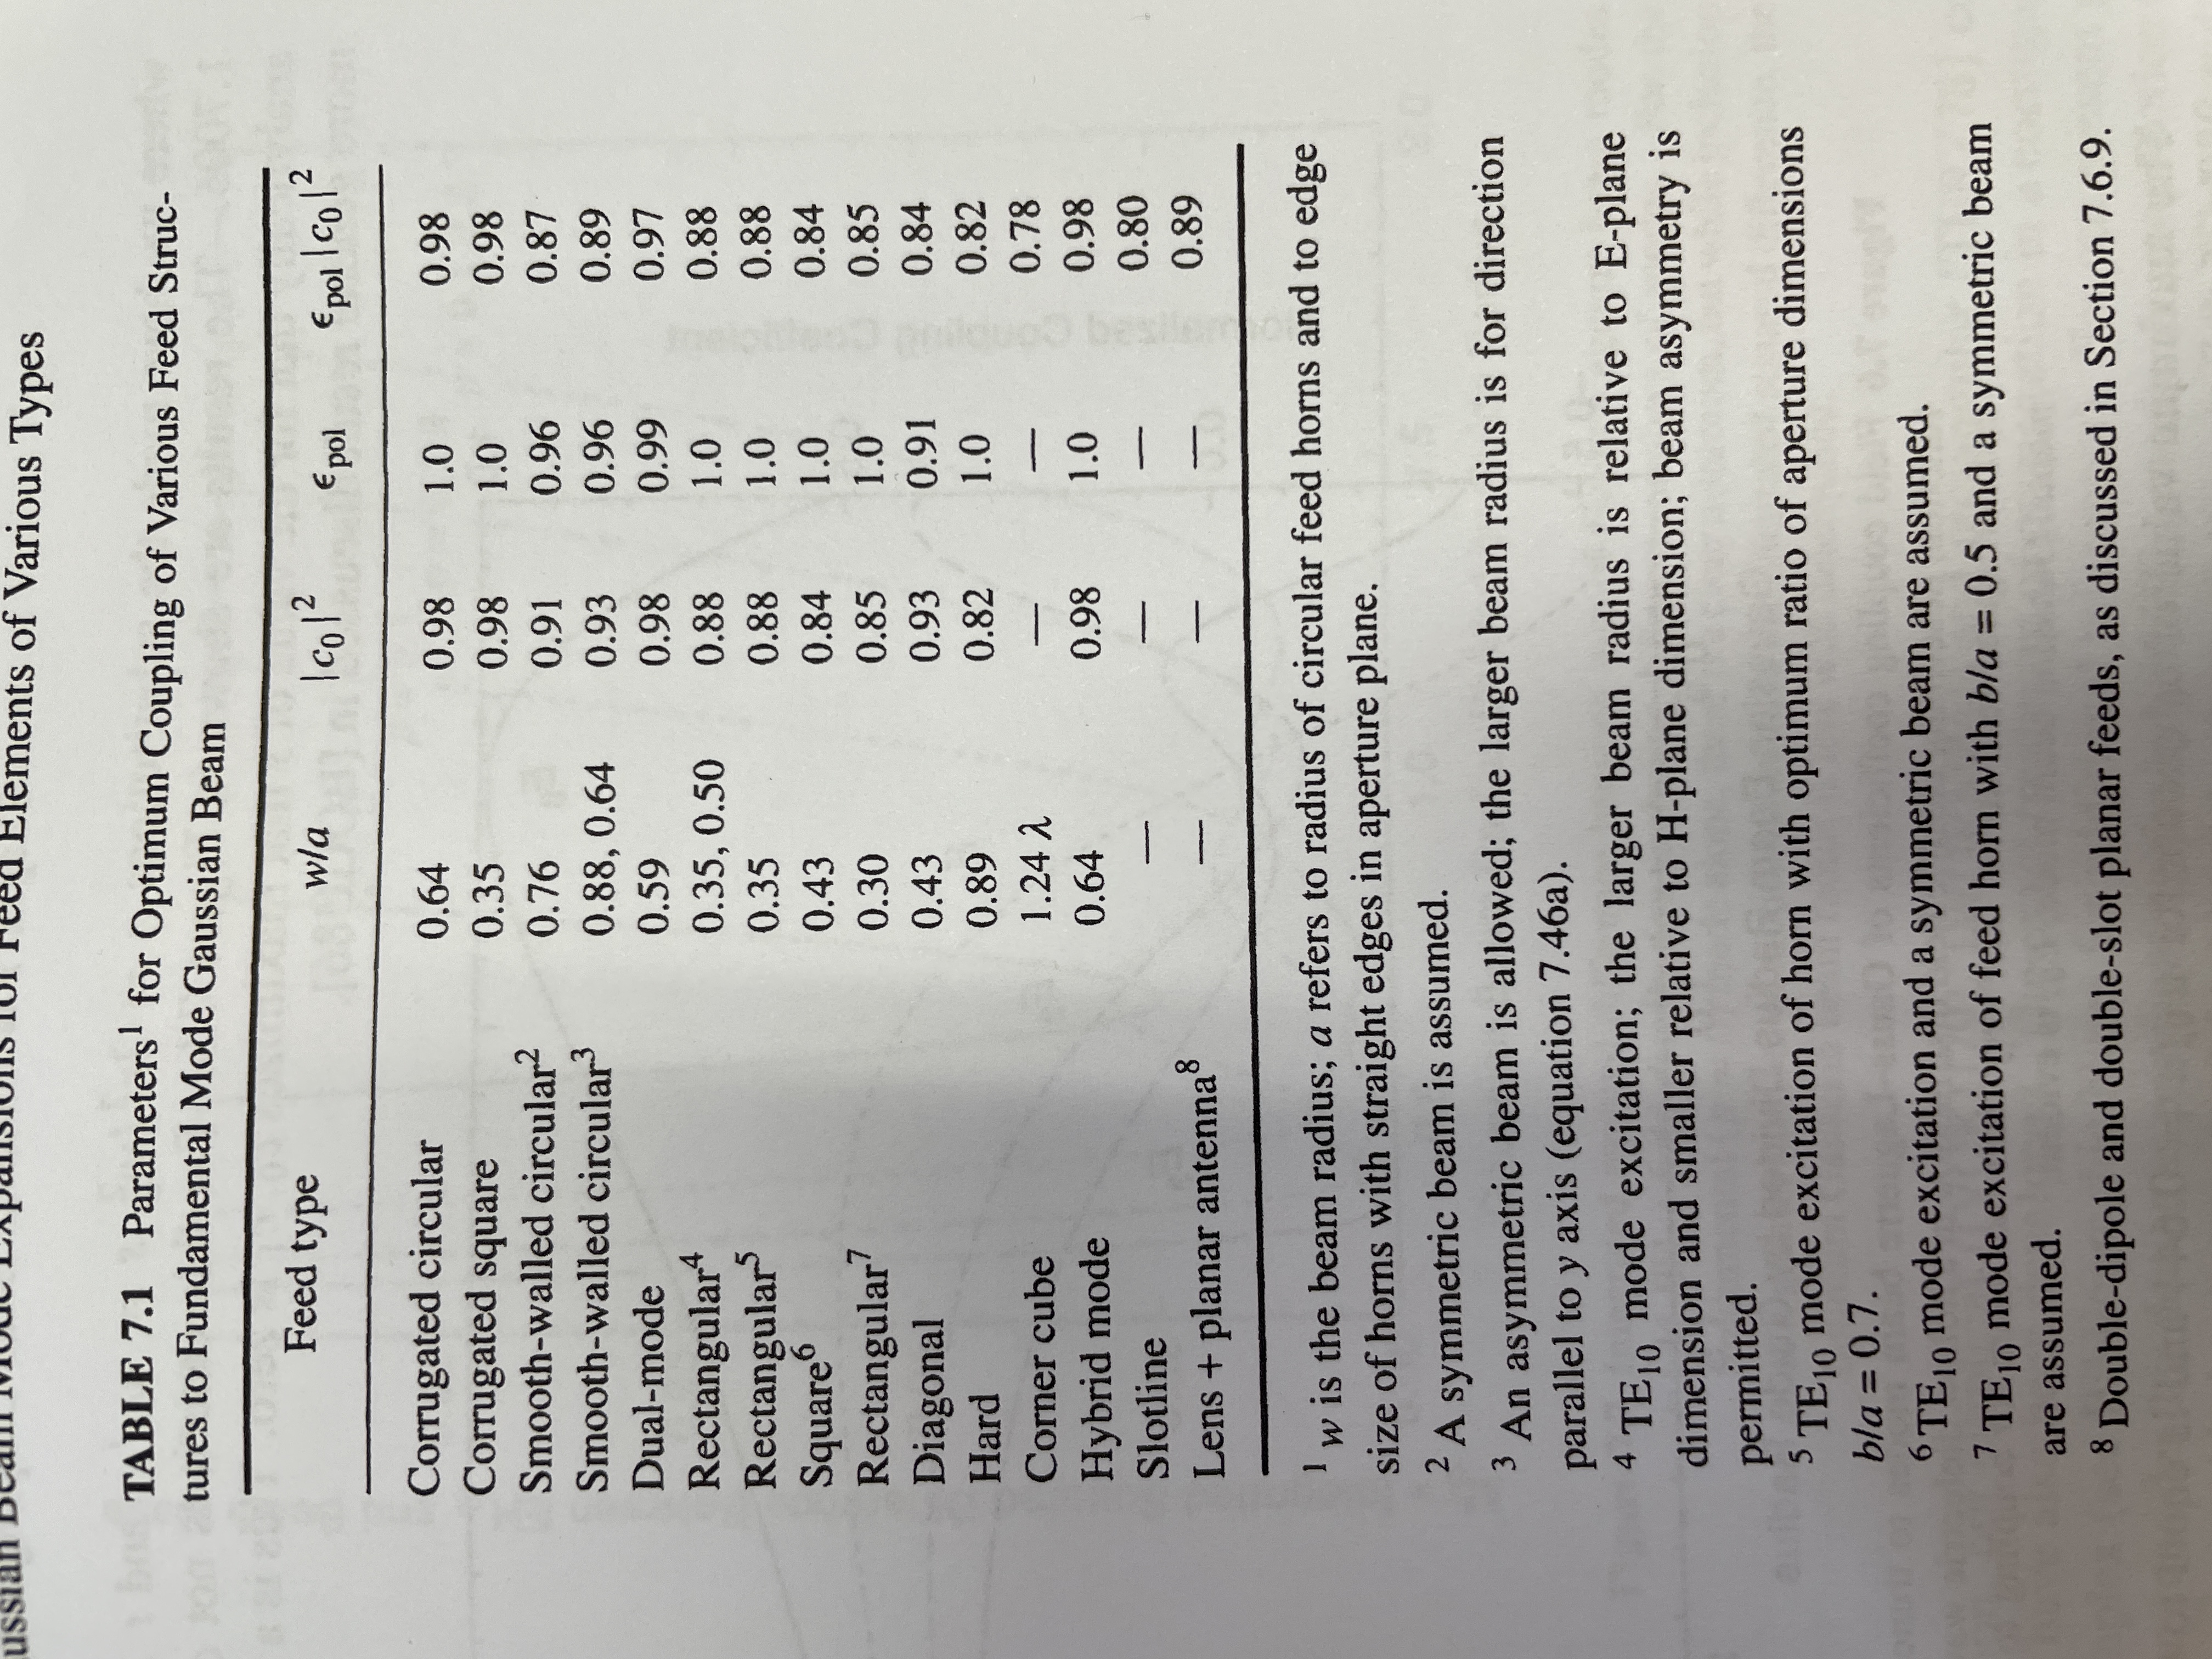

In [104]:
from IPython.display import Image
Image('Goldsmith_table7.1.JPG', width=400)

In [105]:
def calc_antenna_parameters(
    antenna_a,  # waveguid short edge (E-plane)
    antenna_b,  # waveguid long edge (H-plane)
    antenna_L,  # taper section length
    antenna_taper, # taper angle [rad]
    antenna_w_over_A = 0.50, # w/A at aperture in E-plane
    antenna_w_over_B = 0.35, # w/B at aperture in H-plane
    # from P. F. Goldsmith table 7.1 
    # rectangular^5: H-plane = 0.35
    #                           E-plane = 0.50
    wavelength = wavelength,
    verbose = 1,
    ):
    
    if antenna_w_over_B is None:
        antenna_w_over_B = antenna_w_over_A
        pass
    antenna_A = antenna_a + 2. * antenna_L * np.tan(antenna_taper)
    antenna_B = antenna_b + 2. * antenna_L * np.tan(antenna_taper)
    antenna_Ra = antenna_A/2. / np.sin(antenna_taper)
    antenna_Rb = antenna_B/2. / np.sin(antenna_taper)

    # Beam waist
    antenna_wA = antenna_w_over_A * antenna_A
    antenna_wB = antenna_w_over_B * antenna_B
    antenna_w0A = calc_beamwaist0(w=antenna_wA, R=antenna_Ra, wavelength=wavelength)
    antenna_w0B = calc_beamwaist0(w=antenna_wB, R=antenna_Rb, wavelength=wavelength)
    antenna_d0A = calc_waist_distance(w=antenna_wA, R=antenna_Ra, wavelength=wavelength)
    antenna_d0B = calc_waist_distance(w=antenna_wB, R=antenna_Rb, wavelength=wavelength)
    antenna_L0A = antenna_L - antenna_d0A
    antenna_L0B = antenna_L - antenna_d0B

    # Check
    if verbose > 0:
        print(f'a = {antenna_a/mm} mm')
        print(f'b = {antenna_b/mm} mm')
        print(f'A = {antenna_A/mm} mm')
        print(f'B = {antenna_B/mm} mm')
        print(f'Ra = {antenna_Ra/mm} mm')
        print(f'Rb = {antenna_Rb/mm} mm')
        print(f'A/B = {antenna_A/antenna_B}')
        print(f'w_A/A = {antenna_w_over_A}')
        print(f'w_B/B = {antenna_w_over_B}')
        print(f'beam waist in A = {antenna_w0A/mm} mm')
        print(f'beam waist distance from aperture in A = -{antenna_d0A/mm} mm')
        print(f'beam waist distance from antenna bottom in A = {antenna_L0A/mm} mm')
        print(f'beam waist in B = {antenna_w0B/mm} mm')
        print(f'beam waist distance from aperture in B = -{antenna_d0B/mm} mm')
        print(f'beam waist distance from antenna bottom in B = {antenna_L0B/mm} mm')
        print(f'antenna taper angle in A = {np.rad2deg( np.arcsin(antenna_A/2./antenna_Ra) )} deg')
        print(f'antenna taper angle in B = {np.rad2deg( np.arcsin(antenna_B/2./antenna_Rb) )} deg')
        pass
    
    antenna_pars = {
        'L': antenna_L,
        'taper':antenna_taper,
        'w_over_A': antenna_w_over_A, 
        'w_over_B': antenna_w_over_B, 
        
        'a': antenna_a, 
        'A': antenna_A, 
        'Ra': antenna_Ra, 
        'wA': antenna_wA, 
        'w0A': antenna_w0A, 
        'd0A': antenna_d0A, 
        'L0A': antenna_L0A, 
        
        'b': antenna_b, 
        'B': antenna_B, 
        'Rb': antenna_Rb, 
        'wB': antenna_wB, 
        'w0B': antenna_w0B, 
        'd0B': antenna_d0B, 
        'L0B': antenna_L0B, 
        }
    
    return antenna_pars


def calc_circular_antenna_parameters(
    antenna_r, # Radius in aperture
    antenna_L,  # taper section length
    antenna_taperA, # taper angle in E-plane
    antenna_taperB, # taper angle in H-plane
    antenna_w_over_A = 0.644, # w/A at aperture in E-plane
    antenna_w_over_B = 0.644, # w/B at aperture in H-plane
    # from P. F. Goldsmith table 7.1 
    # corrugated circular       : E/H-plane = 0.644 eq. (7.37) in Goldsmith
    # smooth-walled circular: E-plane = 0.88
    #                                          H-plane = 0.64
    wavelength=wavelength,
    verbose = 1,
    ):
    
    if antenna_w_over_B is None:
        antenna_w_over_B = antenna_w_over_A
        pass
    #antenna_A = antenna_R*2. # aperture diameter in E-plane
    #antenna_B = antenna_R*2. # aperture diameter in H-plane
    antenna_rA = antenna_r # aperture radius in E-plane
    antenna_rB = antenna_r # aperture radius in H-plane
    antenna_Ra = antenna_rA / np.sin(antenna_taperA) # curvature at antenna aperture in E-plane
    antenna_Rb = antenna_rB / np.sin(antenna_taperB) # curvature at antenna aperture in H-plane

    # Beam waist
    #antenna_wA = antenna_w_over_A * antenna_A
    #antenna_wB = antenna_w_over_B * antenna_B
    antenna_wA = antenna_w_over_A * antenna_rA
    antenna_wB = antenna_w_over_B * antenna_rB
    antenna_w0A = calc_beamwaist0(w=antenna_wA, R=antenna_Ra, wavelength=wavelength)
    antenna_w0B = calc_beamwaist0(w=antenna_wB, R=antenna_Rb, wavelength=wavelength)
    antenna_d0A = calc_waist_distance(w=antenna_wA, R=antenna_Ra, wavelength=wavelength)
    antenna_d0B = calc_waist_distance(w=antenna_wB, R=antenna_Rb, wavelength=wavelength)
    antenna_L0A = antenna_L - antenna_d0A
    antenna_L0B = antenna_L - antenna_d0B

    # Check
    if verbose > 0:
        print(f'rA = {antenna_rA/mm} mm')
        print(f'rB = {antenna_rB/mm} mm')
        print(f'Ra = {antenna_Ra/mm} mm')
        print(f'Rb = {antenna_Rb/mm} mm')
        print(f'w_A/A = {antenna_w_over_A}')
        print(f'w_B/B = {antenna_w_over_B}')
        print(f'beam waist in A = {antenna_w0A/mm} mm')
        print(f'beam waist distance from aperture in A = -{antenna_d0A/mm} mm')
        print(f'beam waist distance from antenna bottom in A = {antenna_L0A/mm} mm')
        print(f'beam waist in B = {antenna_w0B/mm} mm')
        print(f'beam waist distance from aperture in B = -{antenna_d0B/mm} mm')
        print(f'beam waist distance from antenna bottom in B = {antenna_L0B/mm} mm')
        print(f'antenna taper angle in A = {np.rad2deg( np.arcsin(antenna_r/antenna_Ra) )} deg')
        print(f'antenna taper angle in B = {np.rad2deg( np.arcsin(antenna_r/antenna_Rb) )} deg')
        pass
    
    antenna_pars = {
        'L': antenna_L,
        'taper':antenna_taper,
        'w_over_A': antenna_w_over_A, 
        'w_over_B': antenna_w_over_B, 
        
        'rA': antenna_rA, 
        'Ra': antenna_Ra, 
        'wA': antenna_wA, 
        'w0A': antenna_w0A, 
        'd0A': antenna_d0A, 
        'L0A': antenna_L0A, 
        
        'rB': antenna_rB, 
        'Rb': antenna_Rb, 
        'wB': antenna_wB, 
        'w0B': antenna_w0B, 
        'd0B': antenna_d0B, 
        'L0B': antenna_L0B, 
        }
    
    return antenna_pars

## Corrugated Horn antenna

taper = 6.363711301802121 deg
rA = 3.88 mm
rB = 3.88 mm
Ra = 35.00557119444016 mm
Rb = 35.00557119444016 mm
w_A/A = 0.644
w_B/B = 0.644
beam waist in A = 2.318520030909021 mm
beam waist distance from aperture in A = -4.866928672061902 mm
beam waist distance from antenna bottom in A = 24.5430713279381 mm
beam waist in B = 2.318520030909021 mm
beam waist distance from aperture in B = -4.866928672061902 mm
beam waist distance from antenna bottom in B = 24.5430713279381 mm
antenna taper angle in A = 6.363711301802121 deg
antenna taper angle in B = 6.363711301802121 deg
w0 = 2.318520030909021 mm
d_waist = 4.866928672061902 mm
L_waist = 24.5430713279381 mm
w0 in H-plane = 2.318520030909021 mm
d_waist in H-plane = 4.866928672061902 mm
L_waist in H-plane = 24.5430713279381 mm


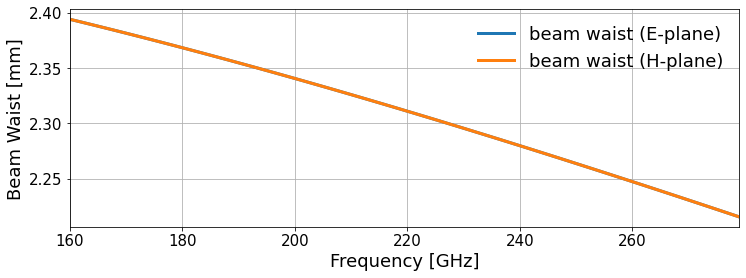

In [288]:
antenna_r0 = 0.6*mm
antenna_r1 = 3.88*mm
antenna_L = 29.41*mm
antenna_taper = np.arctan( (antenna_r1 - antenna_r0)/antenna_L )
print(f'taper = {np.rad2deg(antenna_taper)} deg')
antenna_pars = calc_circular_antenna_parameters(
    antenna_r=antenna_r1,
    antenna_taperA = antenna_taper, 
    antenna_taperB = antenna_taper, 
    antenna_L=antenna_L, 
    antenna_w_over_A = 0.644, # corrugated horn E-plane
    antenna_w_over_B = 0.644, # corrugated horn H-plane
)

w0 = antenna_pars['w0A'] # beam waist in E-plane
w0H = antenna_pars['w0B'] # beam waist in H-plane
d_waist = antenna_pars['d0A'] # distance from waist to aperture
L_waist = antenna_pars['L0A'] # distance from antenna bottom to beam waist
d_waistH = antenna_pars['d0B'] # distance from waist to aperture
L_waistH = antenna_pars['L0B'] # distance from antenna bottom to beam waist
print(f'w0 = {w0/mm} mm')
print(f'd_waist = {d_waist/mm} mm')
print(f'L_waist = {L_waist/mm} mm')
print(f'w0 in H-plane = {w0H/mm} mm')
print(f'd_waist in H-plane = {d_waistH/mm} mm')
print(f'L_waist in H-plane = {L_waistH/mm} mm')

w0_list = []
w0H_list = []
d_waist_list = []
L_waist_list = []
d_waistH_list = []
L_waistH_list = []
for _wl in wavelength_list:
    _pars = calc_circular_antenna_parameters(
    antenna_r=antenna_r1,
    antenna_taperA = antenna_taper, 
    antenna_taperB = antenna_taper, 
    antenna_L=antenna_L, 
    antenna_w_over_A = 0.644, # corrugated horn E-plane
    antenna_w_over_B = 0.644, # corrugated horn H-plane
    wavelength=_wl,
    verbose=-1,
    )
    w0_list.append( _pars['w0A'] )
    w0H_list.append( _pars['w0B'] )
    d_waist_list.append( _pars['d0A'] )
    L_waist_list.append( _pars['L0A'] )
    d_waistH_list.append( _pars['d0B'] )
    L_waistH_list.append( _pars['L0B'] )
    pass
w0_list = np.array(w0_list)
w0H_list = np.array(w0H_list)
d_waist_list = np.array(d_waist_list)
d_waistH_list = np.array(d_waistH_list)
L_waist_list = np.array(L_waist_list)
L_waistH_list = np.array(L_waistH_list)

# w0 plot
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
ax=axs
ax.plot(freq_list/GHz, w0_list/mm, label='beam waist (E-plane)', lw=3)
ax.plot(freq_list/GHz, w0H_list/mm, label='beam waist (H-plane)', lw=3)
ax.grid(True)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Beam Waist [mm]')
ax.set_xlim([freq_list[0]/GHz, freq_list[-1]/GHz])
ax.legend(frameon=False)

## Distance between antenna and parabolic mirror

In [11]:
beamsize_mirror = 95*mm # coherent length/10 @ 215 GHz
_w0 = w0

z_mirror = calc_distance_from_beamsize(w=beamsize_mirror, w0=_w0, wavelength=wavelength)
d_mirror = z_mirror - np.abs(d_waist)
R_mirror = calc_R(z=z_mirror, w0=_w0, wavelength=wavelength)

print(f'beamsize (w) @ mirror = {beamsize_mirror/mm} mm')
print(f'distance from antenna aperture = {d_mirror/mm} mm')
print(f'z from beamwaist @ mirror = {z_mirror/mm} mm')
print(f'R @ mirror = {R_mirror/mm} mm')

print()
print(f'Mirror distance from antenna bottom = {(d_mirror + antenna_L)/mm} mm')

beamsize (w) @ mirror = 95.0 mm
distance from antenna aperture = 491.23704996233374 mm
z from beamwaist @ mirror = 496.1039786343956 mm
R @ mirror = 496.3996477476186 mm

Mirror distance from antenna bottom = 520.6470499623338 mm


In [12]:
def calc_mirror_distance(
    w0, L, d_waist,
    beamsize_mirror = 250*mm/2.,
):
    
    z_mirror = calc_distance_from_beamsize(w=beamsize_mirror, w0=w0, wavelength=wavelength)
    d_mirror = z_mirror - np.abs(d_waist)
    R_mirror = calc_R(z=z_mirror, w0=_w0, wavelength=wavelength)
    L_waist = L - d_waist

    print(f'beamsize (w) @ mirror = {beamsize_mirror/mm} mm')
    print(f'distance from antenna aperture = {d_mirror/mm} mm')
    print(f'z from beamwaist @ mirror = {z_mirror/mm} mm')
    print(f'R @ mirror = {R_mirror/mm} mm')
    print()
    print(f'f = {R_mirror/2./mm} mm')
    print(f'L = {(L)/mm} mm')
    print(f'L_waist = {L_waist/mm} mm')
    print(f'Mirror distance from antenna bottom = {(d_mirror + L)/mm} mm')

    return beamsize_mirror, \
            w0, z_mirror, d_mirror, R_mirror, L_waist

calc_mirror_distance(
    beamsize_mirror = beamsize_mirror,
    w0 = w0,
    L = antenna_L,
    d_waist = d_waist
)

beamsize (w) @ mirror = 95.0 mm
distance from antenna aperture = 491.23704996233374 mm
z from beamwaist @ mirror = 496.1039786343956 mm
R @ mirror = 496.3996477476186 mm

f = 248.1998238738093 mm
L = 29.41 mm
L_waist = 24.5430713279381 mm
Mirror distance from antenna bottom = 520.6470499623338 mm


(0.095,
 0.002318520030909021,
 0.49610397863439565,
 0.49123704996233375,
 0.4963996477476186,
 0.0245430713279381)

# Simulation Expectation

## Mirror Configurations

In [290]:
_mirror = 248.20*mm # focal distance setup in the CST simulation
R_mirror = 2 * f_mirror
z_mirror = 496.10*mm # mirror distance from beam waist at the antenna
w_mirror = calc_beamwaist(w0=w0, z=z_mirror, wavelength=wavelength) # beam size (radius) @ mirror
L_waist = 24.54*mm # distance between the beam waist and antenna bottom (boundary betweeen waveguide and taper sections)
D_mirror = 300.*mm # diameter of the mirror
slant_angle = np.deg2rad(90.)

print(f'Beam waist @ antenna   w0 = {w0/mm:.3f} mm')
print(f'z @ mirror              z = {z_mirror/mm:.3f} mm')
print(f'Distance from antenna aperture to mirror L = {(z_mirror-d_waist)/mm:.3f} mm')
print(f'beam size @ mirror      w = {w_mirror/mm:.3f} mm')
print(f'Focal distance          f = {f_mirror/mm} mm')
print(f'Curvature of the mirror R = {R_mirror/mm} mm')
print(f'Slant angle               = {np.rad2deg(slant_angle):.0f} deg')

# H-plane calculation
#  z is distance from the beam waist in H-plane
zH_mirror = z_mirror - L_waist + L_waistH
#  beaisize in H-plane at zH_mirror
wH_mirror = calc_beamwaist(w0=w0H, z=zH_mirror, wavelength=wavelength )
print(f'--- H-plane ---')
print(f'Beam size @ mirror in H-plane w = {wH_mirror/mm:.3f} mm')
print(f'z @ mirror in H-plane         z = {zH_mirror/mm:.3f} mm')

Beam waist @ antenna   w0 = 2.319 mm
z @ mirror              z = 496.100 mm
Distance from antenna aperture to mirror L = 491.233 mm
beam size @ mirror      w = 94.999 mm
Focal distance          f = 248.2 mm
Curvature of the mirror R = 496.4 mm
Slant angle               = 90 deg
--- H-plane ---
Beam size @ mirror in H-plane w = 95.000 mm
z @ mirror in H-plane         z = 496.103 mm


## Frequency Dependence at Mirror

[1.60e+11 1.61e+11 1.62e+11 ... 2.77e+11 2.78e+11 2.79e+11]
Beamsize (E-plane): 117.35 mm @ 170 GHz
Beamsize (H-plane): 117.35 mm @ 170 GHz
Beamsize (E-plane): 95.00 mm @ 215 GHz
Beamsize (H-plane): 95.00 mm @ 215 GHz
Beamsize (E-plane): 80.75 mm @ 260 GHz
Beamsize (H-plane): 80.75 mm @ 260 GHz


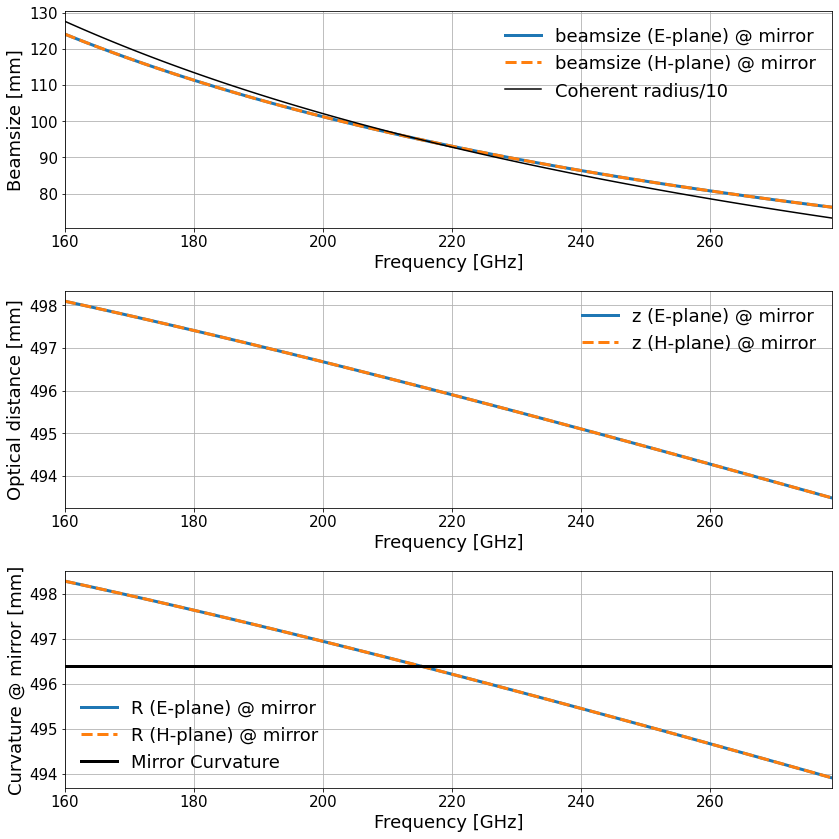

In [291]:
# Frequency dependence
w_mirror_list = []
z_mirror_list = []
R_mirror_list = []
wH_mirror_list = []
zH_mirror_list = []
RH_mirror_list = []
for i, _wl in enumerate(wavelength_list):
    # E-plane
    _w0 = w0_list[i]
    _z = z_mirror - L_waist + L_waist_list[i]
    _R = calc_R(w0=_w0, z=_z, wavelength=_wl)
    w_mirror_list.append( calc_beamwaist(w0=_w0, z=_z, wavelength=_wl) )
    z_mirror_list.append( _z )
    R_mirror_list.append( _R )
    # H-plane
    _w0 = w0H_list[i]
    _z = z_mirror - L_waist + L_waistH_list[i]
    _R = calc_R(w0=_w0, z=_z, wavelength=_wl)
    wH_mirror_list.append( calc_beamwaist(w0=_w0, z=_z, wavelength=_wl) )
    zH_mirror_list.append( _z )
    RH_mirror_list.append( _R )
    pass
w_mirror_list = np.array( w_mirror_list )
z_mirror_list = np.array( z_mirror_list )
R_mirror_list = np.array( R_mirror_list )
wH_mirror_list = np.array( wH_mirror_list )
zH_mirror_list = np.array( zH_mirror_list )
RH_mirror_list = np.array( RH_mirror_list )

# Plot
print(freq_list)
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

ax=axs[0]
ax.plot(freq_list/GHz, w_mirror_list/mm, label='beamsize (E-plane) @ mirror', lw=3)
ax.plot(freq_list/GHz, wH_mirror_list/mm, label='beamsize (H-plane) @ mirror', ls='--', lw=3)
ax.plot(freq_list/GHz, coherent_range/2./mm, label='Coherent radius/10', c='k')
ax.grid(True)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Beamsize [mm]')
ax.set_xlim([freq_list[0]/GHz, freq_list[-1]/GHz])
ax.legend(frameon=False)

ax=axs[1]
ax.plot(freq_list/GHz, z_mirror_list/mm, label='z (E-plane) @ mirror', lw=3)
ax.plot(freq_list/GHz, zH_mirror_list/mm, label='z (H-plane) @ mirror', lw=3, ls='--')
ax.grid(True)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Optical distance [mm]')
ax.set_xlim([freq_list[0]/GHz, freq_list[-1]/GHz])
ax.legend(frameon=False)

ax=axs[2]
ax.plot(freq_list/GHz, R_mirror_list/mm, label='R (E-plane) @ mirror', lw=3)
ax.plot(freq_list/GHz, RH_mirror_list/mm, label='R (H-plane) @ mirror', lw=3, ls='--')
ax.plot(freq_list/GHz, np.full(len(freq_list), R_mirror/mm), label='Mirror Curvature', lw=3, c='k')
ax.grid(True)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Curvature @ mirror [mm]')
ax.set_xlim([freq_list[0]/GHz, freq_list[-1]/GHz])
ax.legend(frameon=False)

fig.tight_layout()

# Print values
print(f'Beamsize (E-plane): {func.interpolate1D(freq_list/GHz, w_mirror_list, 170.)/mm:.2f} mm @ 170 GHz')
print(f'Beamsize (H-plane): {func.interpolate1D(freq_list/GHz, wH_mirror_list, 170.)/mm:.2f} mm @ 170 GHz')
print(f'Beamsize (E-plane): {func.interpolate1D(freq_list/GHz, w_mirror_list, 215.)/mm:.2f} mm @ 215 GHz')
print(f'Beamsize (H-plane): {func.interpolate1D(freq_list/GHz, wH_mirror_list, 215.)/mm:.2f} mm @ 215 GHz')
print(f'Beamsize (E-plane): {func.interpolate1D(freq_list/GHz, w_mirror_list, 260.)/mm:.2f} mm @ 260 GHz')
print(f'Beamsize (H-plane): {func.interpolate1D(freq_list/GHz, wH_mirror_list, 260.)/mm:.2f} mm @ 260 GHz')

## Beam between Antenna and Mirror

z_antenna_list        = [-100.  -90.  -80. ...  970.  980.  990.] mm
beamsize_antenna_list = [ 19.28339761  17.38445813  15.48931321 ... 185.70649874 187.62070183
 189.53490791] mm
R_antenna_list        = [-101.46682623  -91.62980693  -81.83353279 ...  970.1512192   980.14967615
  990.14816427] mm


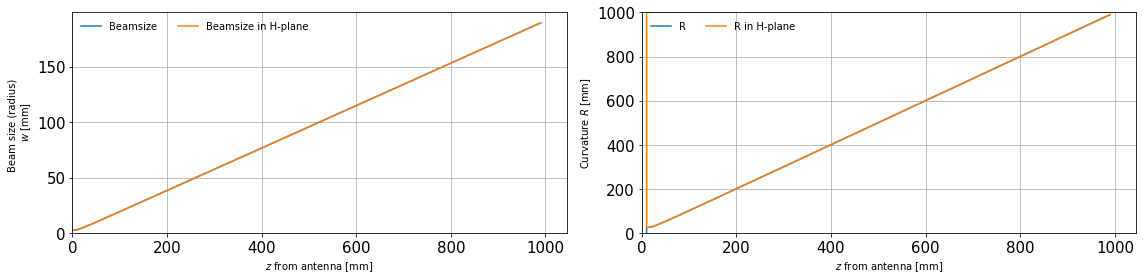

In [14]:
_dz = 10*mm
z_antenna_list = np.arange(-100*mm, 1, _dz)  # z position from reflection
beamsize_antenna_list = calc_beamwaist(z=z_antenna_list, w0=w0, wavelength=wavelength)
R_antenna_list = calc_R(z=z_antenna_list, w0=w0, wavelength=wavelength)
zH_antenna_list = np.arange(0*mm, 1, _dz) - L_waist + L_waistH  # z position from reflection
beamsizeH_antenna_list = calc_beamwaist(z=zH_antenna_list, w0=w0H, wavelength=wavelength)
RH_antenna_list = calc_R(z=zH_antenna_list, w0=w0H, wavelength=wavelength)
print(f'z_antenna_list        = {z_antenna_list/mm} mm')
print(f'beamsize_antenna_list = {beamsize_antenna_list/mm} mm')
print(f'R_antenna_list        = {R_antenna_list/mm} mm')

fig, ax = plt.subplots(1, 2, figsize=(16,4))
_ax = ax[0]
_ax.plot(z_antenna_list/mm, beamsize_antenna_list/mm, label='Beamsize')
_ax.plot(zH_antenna_list/mm, beamsizeH_antenna_list/mm, label='Beamsize in H-plane')
_ax.set_xlabel('$z$ from antenna [mm]')
_ax.set_ylabel('Beam size (radius) \n $w$ [mm]')
_ax.legend(frameon=False, ncol=2)
_ax.grid(True)
_ax.set_xlim(left=0)
_ax.set_ylim(bottom=0)
_ax = ax[1]
_ax.plot(z_antenna_list/mm, R_antenna_list/mm, label='R')
_ax.plot(zH_antenna_list/mm, RH_antenna_list/mm, label='R in H-plane')
_ax.set_xlabel('$z$ from antenna [mm]')
_ax.set_ylabel('Curvature $R$ [mm]')
_ax.legend(frameon=False, ncol=2)
_ax.grid(True)
_ax.set_xlim(left=0)
_ax.set_ylim(bottom=0, top=1/mm)

fig.tight_layout()
#ax.set_xlim([0, 200])
#ax.set_ylim([0, 200])

## Beam after mirror

In [15]:
height_after_ref = 2*f_mirror / np.sin(slant_angle) * np.abs(np.cos(slant_angle) - 1.)
print(f'height after reflection = {height_after_ref/mm} mm')

height after reflection = 496.3999999999999 mm


In [16]:
z_mirror_list = np.arange(0*mm, 2000*mm+_dz, _dz)  # z position from reflection
beamsize_mirror_list = calc_beamwaist(z=z_mirror_list, w0=w_mirror, wavelength=wavelength)
beamsizeH_mirror_list = calc_beamwaist(z=z_mirror_list, w0=wH_mirror, wavelength=wavelength)
print(f'z_mirror_list (after mirror) = {z_mirror_list/mm} mm')
print(f'beamsize_mirror_list (after mirror) = {beamsize_mirror_list/mm} mm')

z_mirror_list (after mirror) = [   0.   10.   20. ... 1980. 1990. 2000.] mm
beamsize_mirror_list (after mirror) = [94.99923858 94.99925007 94.99928453 ... 95.44858249 95.45312196
 95.45768408] mm


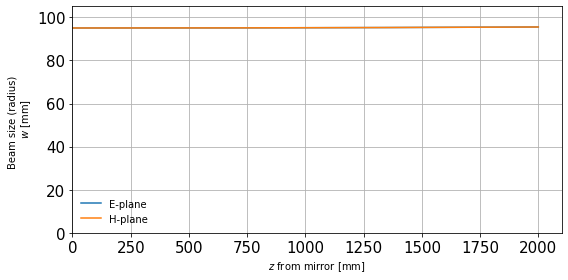

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(z_mirror_list/mm, beamsize_mirror_list/mm, label='E-plane')
ax.plot(z_mirror_list/mm, beamsizeH_mirror_list/mm, label='H-plane')
ax.set_xlabel('$z$ from mirror [mm]')
ax.set_ylabel('Beam size (radius) \n $w$ [mm]')
ax.grid(True)
ax.set_ylim(bottom=0, top=max(np.hstack([beamsize_mirror_list, beamsizeH_mirror_list])/mm*1.1))
ax.set_xlim(left=0)
ax.legend(frameon=False)
fig.tight_layout()

## Beam for all path

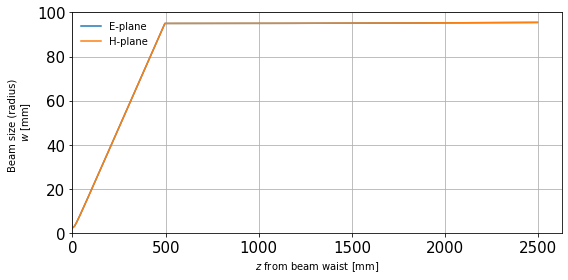

In [18]:
# E-plane
z_mirror_list_from_antenna = z_mirror_list + z_mirror
i_before_mirror = np.where( z_antenna_list < z_mirror)
z_list = np.hstack([z_antenna_list[i_before_mirror], z_mirror_list_from_antenna])
beamsize_list = np.hstack([beamsize_antenna_list[i_before_mirror], beamsize_mirror_list])
# H-plane
zH_mirror_list_from_antenna = z_mirror_list + zH_mirror
i_before_mirrorH = np.where( zH_antenna_list < zH_mirror)
zH_list = np.hstack([zH_antenna_list[i_before_mirrorH], zH_mirror_list_from_antenna])
beamsizeH_list = np.hstack([beamsizeH_antenna_list[i_before_mirrorH], beamsizeH_mirror_list])

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(z_list/mm, beamsize_list/mm, label='E-plane')
ax.plot(zH_list/mm, beamsizeH_list/mm, label='H-plane')
ax.set_xlabel('$z$ from beam waist [mm]')
ax.set_ylabel('Beam size (radius) \n $w$ [mm]')
ax.grid(True)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.legend(frameon=False)
fig.tight_layout()

# Plot CST data

## v8-4 215 GHz

### W v.s. V at U=0 (E-plane)

E-Field_Abs_Ave_U0_215GHz.dat
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_Abs_Ave_U0_215GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-100.  -99.  -98. ...  498.  499.  500.]
y_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
w = 100 mm
w = 200 mm
w = 300 mm
w = 400 mm
w = 500 mm


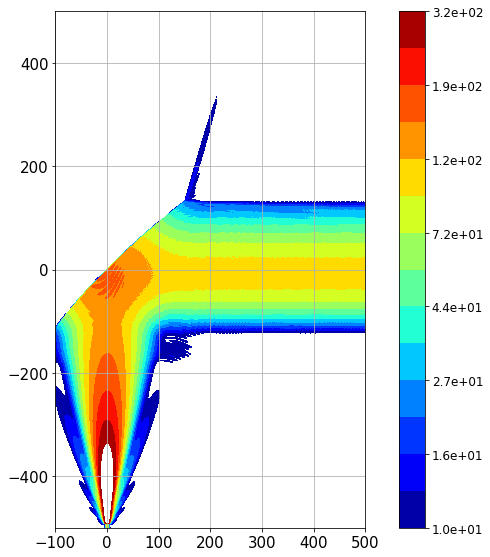

In [43]:
_indir = 'input/CST/215GHz_v8-4-215GHz/215GHz'
#_infile = 'E-field_abs_ave_w-v.txt'
_infile = 'E-Field_Abs_Ave_U0_215GHz.dat'
_w_list_mm = np.array([100, 200, 300, 400, 500])
_w_list= _w_list_mm * mm
_label_list = [ f'z={_w:.0f} mm' for _w in _w_list_mm ]

print(_infile)
_newgrid = ( np.linspace(-100, 500, 600+1), np.linspace(-500, 500, 500+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='z', ykey='y', newgrid=_newgrid, title='')

### Create slice data list ###
_slicedata_list = []
for _w in _w_list_mm:
    print(f'w = {_w} mm')
    _slicedata_list.append( getSlice(_data_grid, 'x', _w) )
    pass

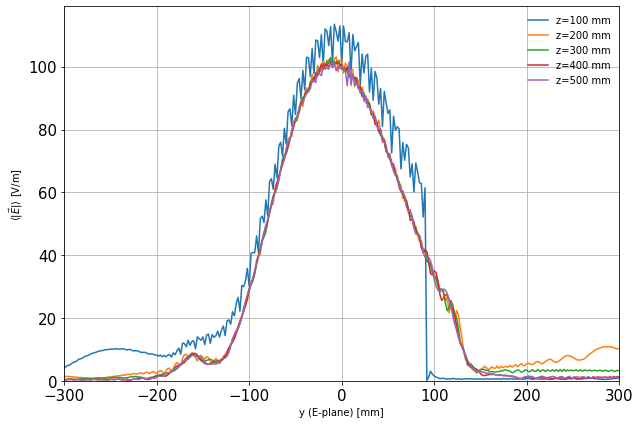

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
for _label, _data in zip(_label_list, _slicedata_list):
    ax.plot( _data['y'], _data['z'], label=_label )
    pass
ax.set_xlim([-300, 300])
ax.set_ylim(bottom=0)
#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.legend(frameon=False)
ax.grid(True)
ax.set_xlabel('y (E-plane) [mm]')
ax.set_ylabel(r'$\langle |\vec{E}| \rangle$ [V/m]')
fig.tight_layout()

x @ y max = -8.0
Beam size @ power = 1/e = 102.42 mm / 99.87 mm
x @ y max = -6.0
Beam size @ power = 1/e = 93.31 mm / 94.69 mm
x @ y max = -12.0
Beam size @ power = 1/e = 91.88 mm / 94.65 mm
x @ y max = -12.0
Beam size @ power = 1/e = 92.10 mm / 94.91 mm
x @ y max = 8.0
Beam size @ power = 1/e = 97.33 mm / 95.44 mm


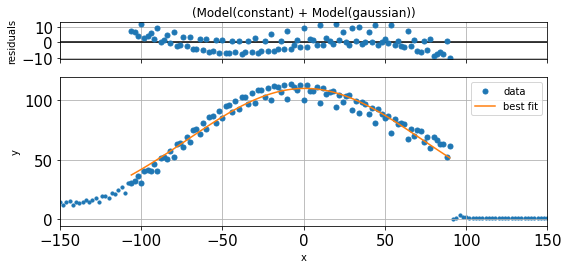

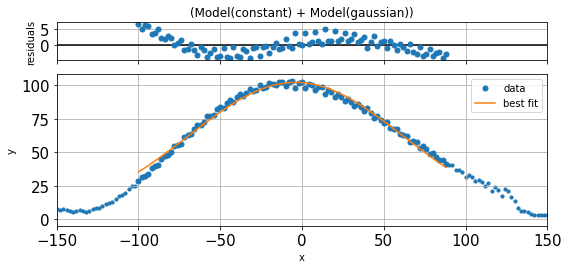

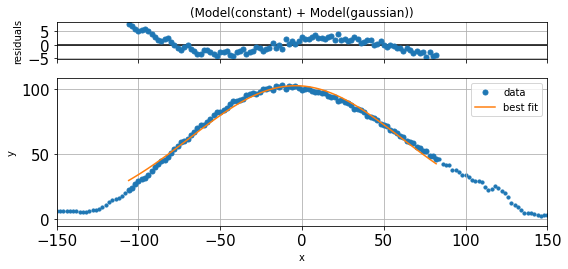

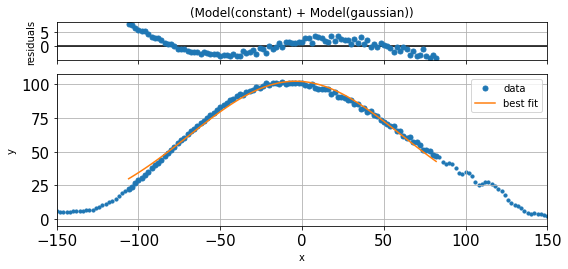

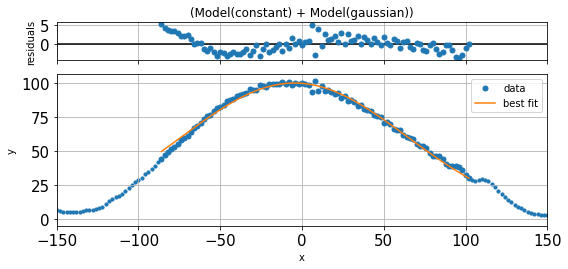

In [45]:
### Calculate beam size ###
_fitresult_list = []
_beamsize_list = []
_beamsize2_list = []
_n_conv = 10
for i, (_label, _data) in enumerate( zip(_label_list, _slicedata_list) ):
    _x = _data['y']
    _y = _data['z']
    # get running average
    _b = np.ones(_n_conv)/_n_conv 
    _x_ave = np.convolve(_x, _b, mode="same") 
    _y_ave = np.convolve(_y, _b, mode="same") 
    
    # Get hwhm from half value
    _fwhm_from_half = fwhm_to_beamsize( get_fwhm_from_half(_x_ave, _y_ave) )
    _beamsize2_list.append( _fwhm_from_half*mm )
    
    _ymax = np.max(_y)
    _i_ymax = np.where(_y==_ymax)
    _x_ymax = _x[_i_ymax][0]
    print(f'x @ y max = {_x_ymax}')
    _range_scale = 1.0
    #_range_scale = 0.5
    _result = gauss_fit(_x, _y, x_fit_range=[_x_ymax-_fwhm_from_half*_range_scale, _x_ymax+_fwhm_from_half*_range_scale], xlim=[-D_mirror/mm/2, D_mirror/mm/2])
    _fitresult_list.append( _result )
    _beamsize_list.append( sigma2beamsize( _result.result.params['sigma'].value )*mm )
    
    print(f'Beam size @ power = 1/e = {_beamsize_list[-1]/mm:.2f} mm / {_beamsize2_list[-1]/mm:.2f} mm')
    pass

#plt.scatter(_slicedata_list[-1]['y'], _slicedata_list[-1]['val0'])
#plt.xlim(-100, 50)
#plt.ylim(30, 45)

_beamsize_list = np.array(_beamsize_list)
_beamsize2_list = np.array(_beamsize2_list)

_beamsize_list_exp (size=(5,)) = [0.09500039 0.09500383 0.09500958 0.09501762 0.09502796]


(0.0, 1095.71)

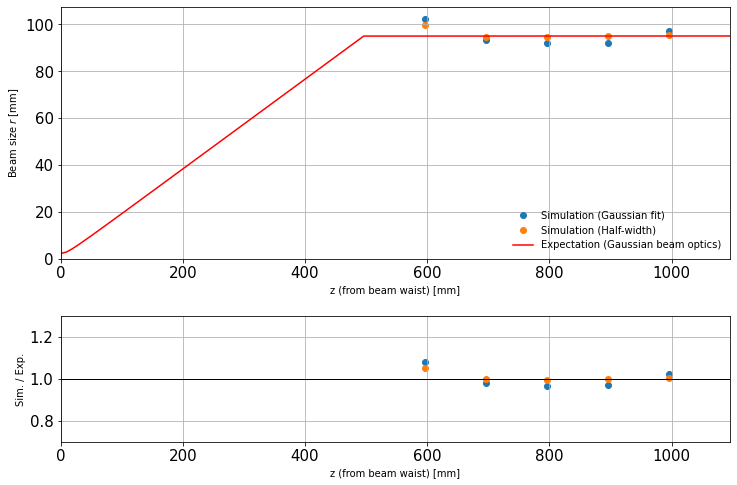

In [46]:
### Draw beam size ###

# Temporary Expectation
#_z_tmp_list = z_antenna_list
#_beamsize_tmp_list = calc_beamwaist(z=_z_tmp_list+20*mm, w0=w0*1.0, wavelength=wavelength)
# Simulation
_z_list = _w_list + z_mirror

# Plot Simulation v.s. Expectation
fig, axs = plt.subplots(2, 1, figsize=(12,8), gridspec_kw={'height_ratios':[2,1], 'hspace':0.3})
ax = axs[0]
sc1 = ax.scatter(_z_list/mm, _beamsize_list/mm, label='Simulation (Gaussian fit)')
sc1_color = sc1.get_facecolors()
sc2 = ax.scatter(_z_list/mm, _beamsize2_list/mm, label='Simulation (Half-width)')
sc2_color = sc2.get_facecolors()
ax.plot(z_list/mm, beamsize_list/mm, label='Expectation (Gaussian beam optics)', c='red')
#ax.plot(_z_tmp_list/mm, _beamsize_tmp_list/mm, label='Expectation (tmp)')
ax.grid(True)
ax.set_xlabel('z (from beam waist) [mm]')
ax.set_ylabel('Beam size $r$ [mm]')
_xlim = [0, max(_z_list/mm)*1.1]
ax.set_xlim(_xlim)
#ax.set_ylim(bottom=0, top=max(_beamsize_list/mm)*1.1)
ax.set_ylim(bottom=0)
#ax.set_yscale('log')
ax.legend(frameon=False, loc='lower right')

ax = axs[1]
ax.grid(True)
_beamsize_list_exp = func.interpolate1D(z_list, beamsize_list, _z_list)
func.print_list(_beamsize_list_exp)
ax.scatter(_z_list/mm, _beamsize_list/_beamsize_list_exp, label='', c=sc1_color)
ax.scatter(_z_list/mm, _beamsize2_list/_beamsize_list_exp, label='', c=sc2_color)
ax.plot(_xlim, [1,1], c='k', lw=1)
ax.set_ylabel('Sim. / Exp.')
ax.set_xlabel('z (from beam waist) [mm]')
ax.set_ylim([0.7, 1.3])
ax.set_xlim(_xlim)

In [47]:
### Save the data ###
data_v84 = {'slicedata_list':_slicedata_list, 
           'z_list':_z_list, 'w_list':_w_list, 
           'beamsize_list':_beamsize_list, 'fitresult_list':_fitresult_list}

### W v.s. U at U=0 (H-plane)

E-Field_Abs_Ave_V0_215GHz.dat
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_Abs_Ave_V0_215GHz.dat (type=3D_twovalue)
x_list (size=(701,)) = [-200. -199. -198. ...  498.  499.  500.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


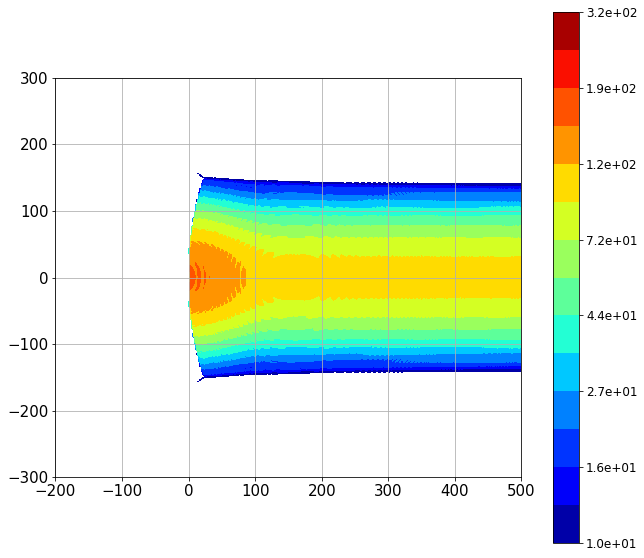

In [49]:
_indir = 'input/CST/215GHz_v8-4-215GHz/215GHz'
#_infile = 'E-field_abs_ave_w-u.txt'
_infile = 'E-Field_Abs_Ave_V0_215GHz.dat'
print(_infile)
_newgrid = ( np.linspace(-200, 500, 700+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='z', ykey='x', newgrid=_newgrid, title='')

### U v.s V at W=300 mm

E-Field_Abs_Ave_W300_215GHz.dat
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_Abs_Ave_W300_215GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


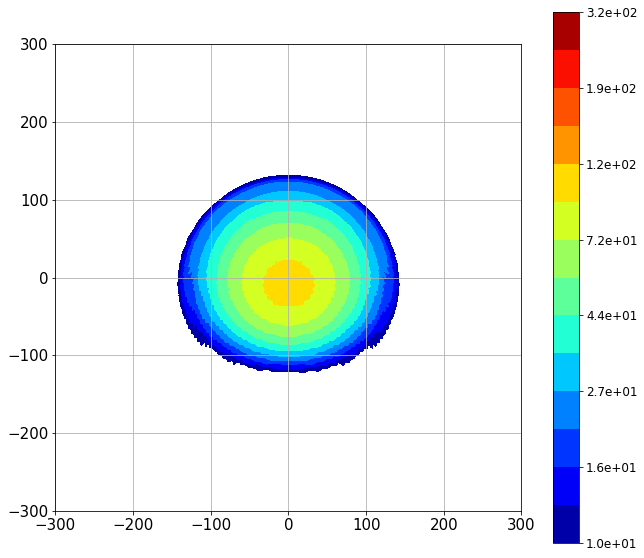

In [48]:
_indir = 'input/CST/215GHz_v8-4-215GHz/215GHz'
#_infile = 'E-field_abs_ave_w300.txt'
_infile = 'E-Field_Abs_Ave_W300_215GHz.dat'
print(_infile)
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='')

## v8-4 170 GHz

### 2D at U=0 (W v.s. V, E-plane)

E-Field_Abs_Ave_U0_170GHz.dat
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_Abs_Ave_U0_170GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-100.  -99.  -98. ...  498.  499.  500.]
y_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
w = 100 mm
w = 200 mm
w = 300 mm
w = 400 mm
w = 500 mm


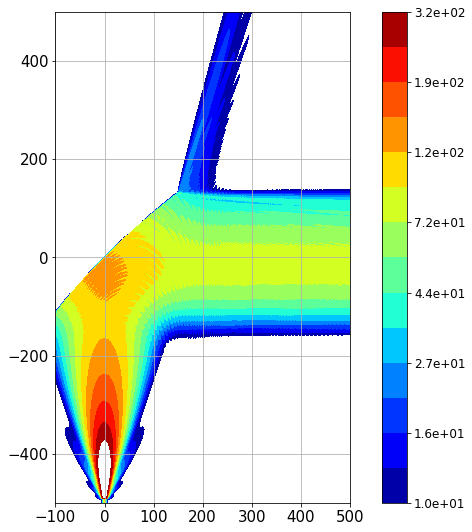

In [90]:
_indir = 'input/CST/215GHz_v8-4-215GHz/170GHz'
_infile = 'E-Field_Abs_Ave_U0_170GHz.dat'
_w_list_mm = np.array([100, 200, 300, 400, 500])
_w_list= _w_list_mm * mm
_label_list = [ f'z={_w:.0f} mm' for _w in _w_list_mm ]

print(_infile)
_newgrid = ( np.linspace(-100, 500, 600+1), np.linspace(-500, 500, 500+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='z', ykey='y', newgrid=_newgrid, title='')

### Create slice data list ###
_slicedata_list = []
for _w in _w_list_mm:
    print(f'w = {_w} mm')
    _slicedata_list.append( getSlice(_data_grid, 'x', _w) )
    pass

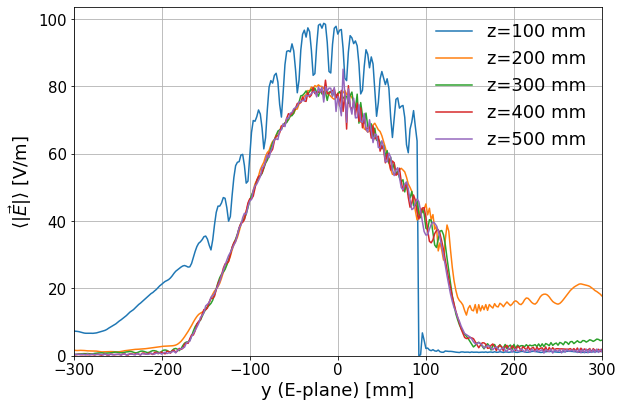

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
for _label, _data in zip(_label_list, _slicedata_list):
    ax.plot( _data['y'], _data['z'], label=_label )
    pass
ax.set_xlim([-300, 300])
ax.set_ylim(bottom=0)
#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.legend(frameon=False)
ax.grid(True)
ax.set_xlabel('y (E-plane) [mm]')
ax.set_ylabel(r'$\langle |\vec{E}| \rangle$ [V/m]')
fig.tight_layout()

### W v.s. U at U=0 (H-plane)

E-Field_Abs_Ave_V0_170GHz.dat
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_Abs_Ave_V0_170GHz.dat (type=3D_twovalue)
x_list (size=(701,)) = [-200. -199. -198. ...  498.  499.  500.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


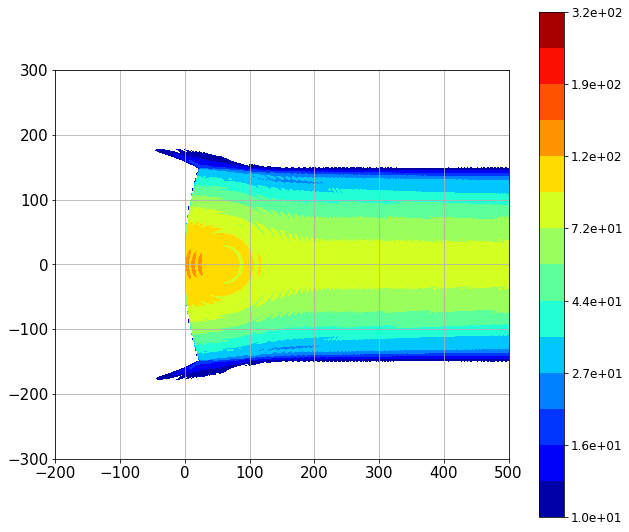

In [92]:
_indir = 'input/CST/215GHz_v8-4-215GHz/170GHz'
_infile = 'E-Field_Abs_Ave_V0_170GHz.dat'
print(_infile)
_newgrid = ( np.linspace(-200, 500, 700+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='z', ykey='x', newgrid=_newgrid, title='')

### U v.s V at W=300 mm

E-Field_Abs_Ave_W300_170GHz.dat
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_Abs_Ave_W300_170GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


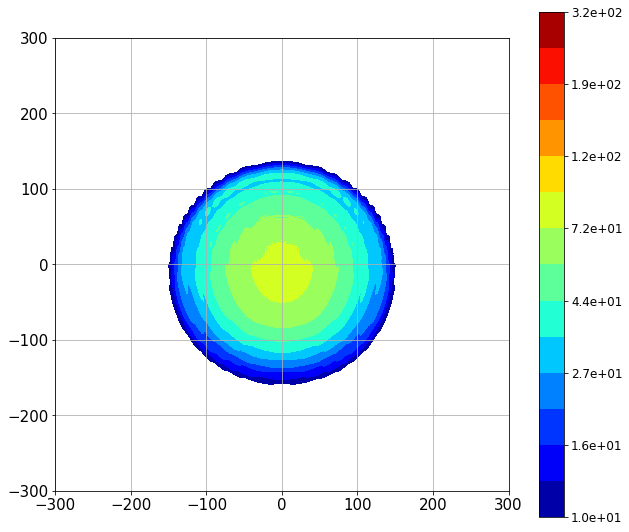

In [93]:
_indir = 'input/CST/215GHz_v8-4-215GHz/170GHz'
_infile = 'E-Field_Abs_Ave_W300_170GHz.dat'
print(_infile)
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='')

## v8-4 260 GHz

### 2D at U=0 (W v.s. V, E-plane)

E-Field_Abs_Ave_U0_260GHz.dat
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_Abs_Ave_U0_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-100.  -99.  -98. ...  498.  499.  500.]
y_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
w = 100 mm
w = 200 mm
w = 300 mm
w = 400 mm
w = 500 mm


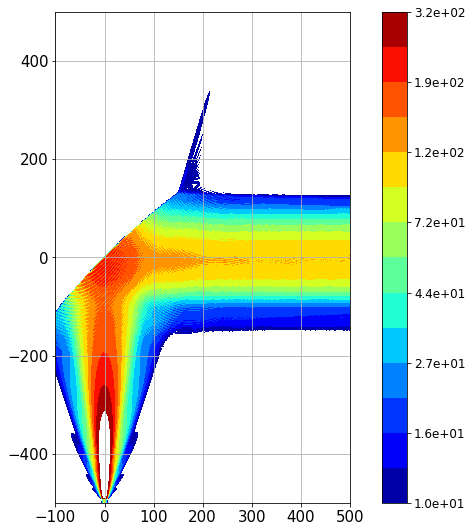

In [249]:
_indir = 'input/CST/215GHz_v8-4-260GHz/260GHz'
_infile = 'E-Field_Abs_Ave_U0_260GHz.dat'
_w_list_mm = np.array([100, 200, 300, 400, 500])
_w_list= _w_list_mm * mm
_label_list = [ f'z={_w:.0f} mm' for _w in _w_list_mm ]

print(_infile)
_newgrid = ( np.linspace(-100, 500, 600+1), np.linspace(-500, 500, 500+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='z', ykey='y', newgrid=_newgrid, title='')

### Create slice data list ###
_slicedata_list = []
for _w in _w_list_mm:
    print(f'w = {_w} mm')
    _slicedata_list.append( getSlice(_data_grid, 'x', _w) )
    pass

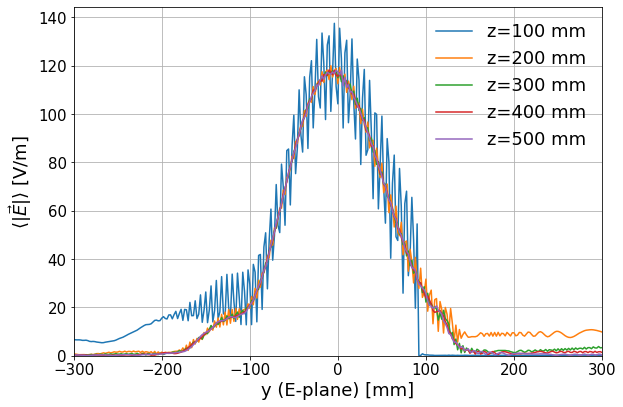

In [250]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
for _label, _data in zip(_label_list, _slicedata_list):
    ax.plot( _data['y'], _data['z'], label=_label )
    pass
ax.set_xlim([-300, 300])
ax.set_ylim(bottom=0)
#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.legend(frameon=False)
ax.grid(True)
ax.set_xlabel('y (E-plane) [mm]')
ax.set_ylabel(r'$\langle |\vec{E}| \rangle$ [V/m]')
fig.tight_layout()

### W v.s. U at U=0 (H-plane)

E-Field_Abs_Ave_V0_260GHz.dat
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_Abs_Ave_V0_260GHz.dat (type=3D_twovalue)
x_list (size=(701,)) = [-200. -199. -198. ...  498.  499.  500.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


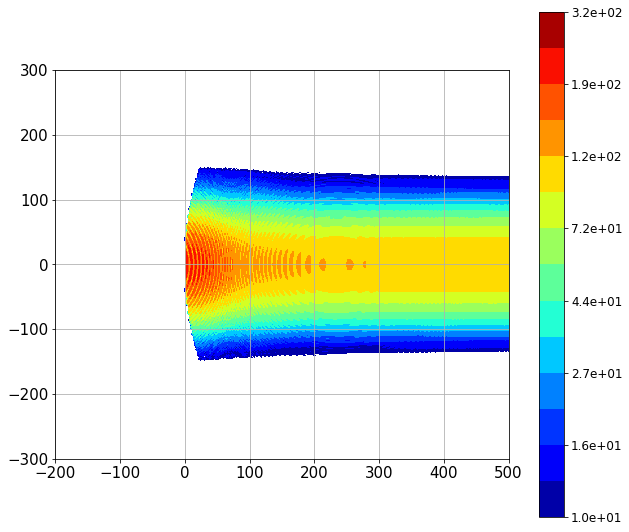

In [251]:
_indir = 'input/CST/215GHz_v8-4-260GHz/260GHz'
_infile = 'E-Field_Abs_Ave_V0_260GHz.dat'
print(_infile)
_newgrid = ( np.linspace(-200, 500, 700+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='z', ykey='x', newgrid=_newgrid, title='')

### U v.s V at W=300 mm

E-Field_Abs_Ave_W300_260GHz.dat
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_Abs_Ave_W300_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


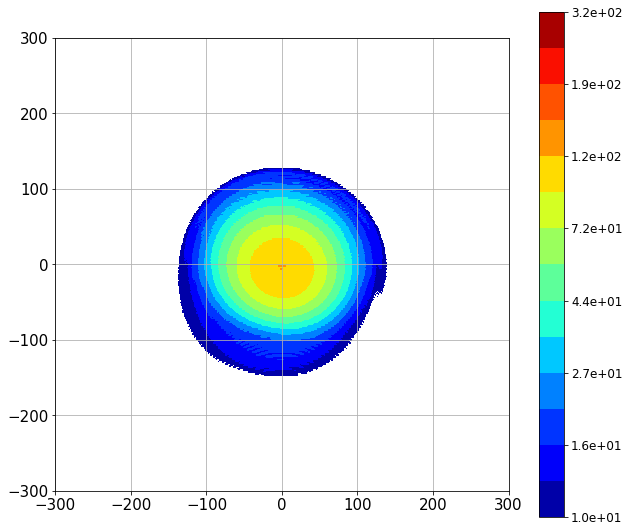

In [252]:
_indir = 'input/CST/215GHz_v8-4-260GHz/260GHz'
_infile = 'E-Field_Abs_Ave_W300_260GHz.dat'
print(_infile)
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='')

### U v.s V at W=400 mm

input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_V_Re_W400_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_V_Im_W400_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]


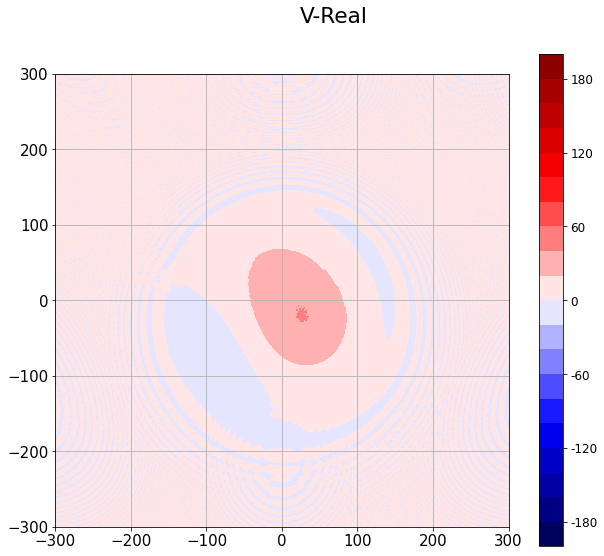

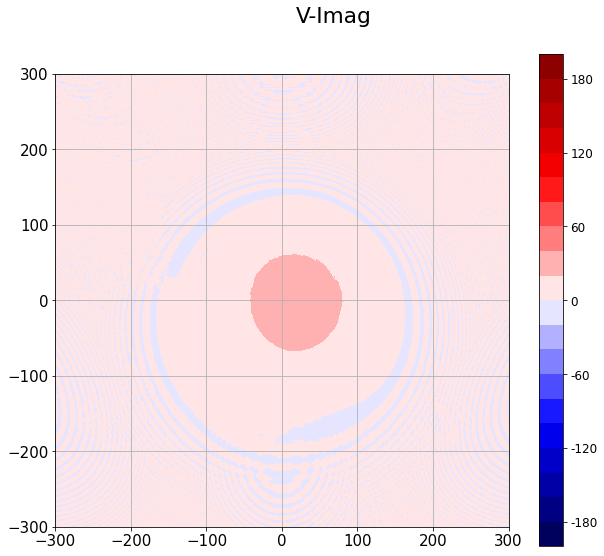

In [294]:
_indir = 'input/CST/215GHz_v8-4-260GHz/260GHz'
'''
_infile = 'E-Field_U_Re_W400_260GHz.dat'
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='')
_infile = 'E-Field_U_Im_W400_260GHz.dat'
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='')
'''
_infile = 'E-Field_V_Re_W400_260GHz.dat'
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='V-Real',
    levels=np.linspace(-200, 200, 20+1), logz=False, cmap='seismic', colorbarformat='%.0f')
_infile = 'E-Field_V_Im_W400_260GHz.dat'
_newgrid = ( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) )
fig, ax, _data_grid = plotCST2D(f'{_indir}/{_infile}', xkey='x', ykey='y', newgrid=_newgrid, title='V-Imag',
    levels=np.linspace(-200, 200, 20+1), logz=False, cmap='seismic', colorbarformat='%.0f')

## v8-4 Beam Pattern at W=300 mm

### 215 GHz

input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_U_Re_W300_215GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_U_Im_W300_215GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_V_Re_W300_215GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_V_Im_W300_215GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/215GHz/E-Field_W_Re_W300_215GHz.dat (type=3D_twova

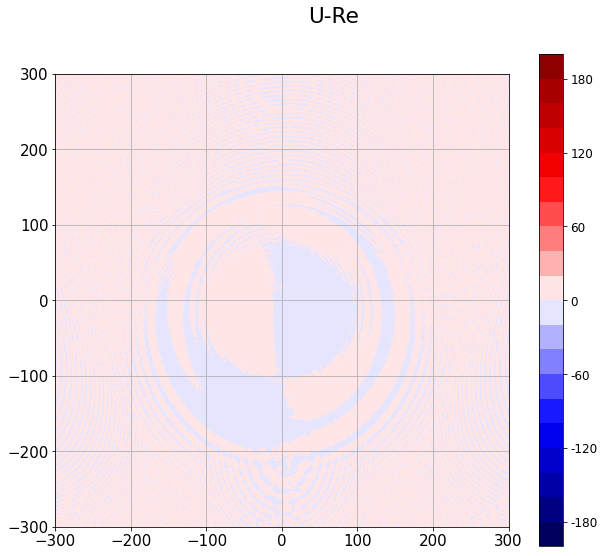

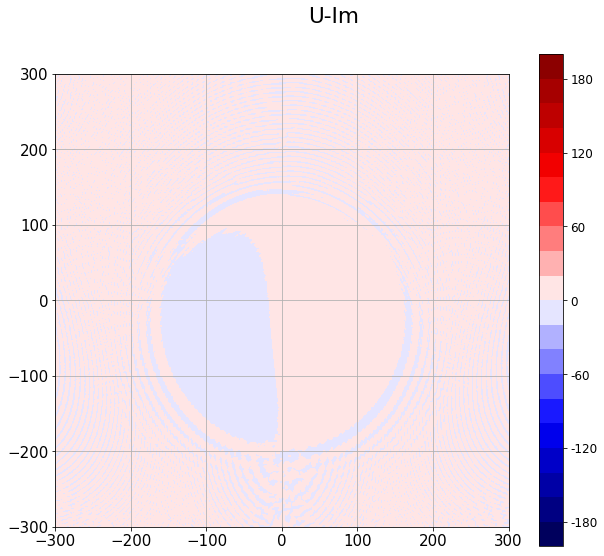

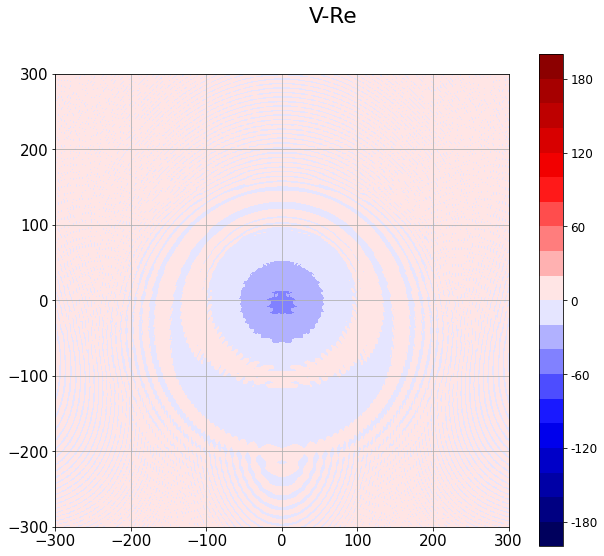

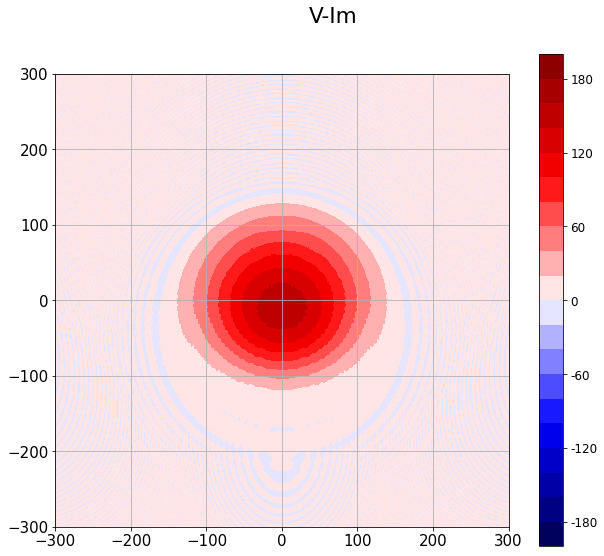

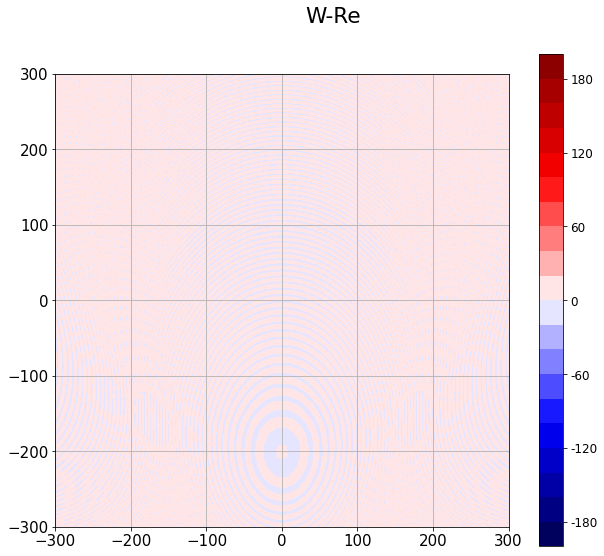

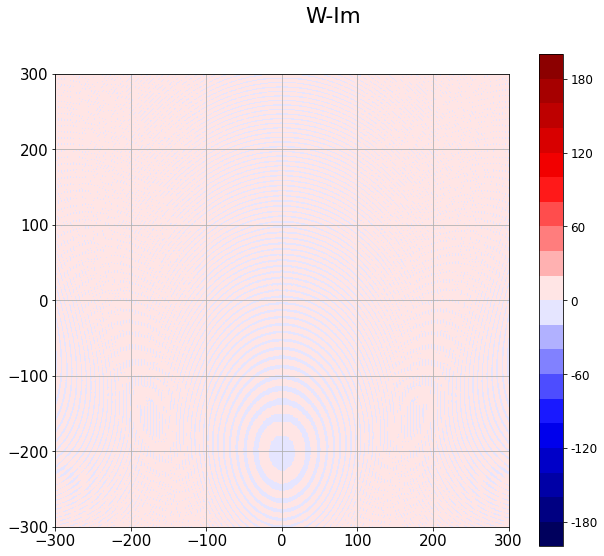

In [295]:
_indir = 'input/CST/215GHz_v8-4-215GHz/215GHz'
_prefix = 'E-Field_'
_suffix = '_W300_215GHz.dat'
_data_dict = read_CST_complex_field(
    indir=_indir,
    prefix=_prefix,
    suffix=_suffix,
    grid=( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) ),
    #levels=np.power(10, np.linspace(-30, 30, 21)/10), logz=True,
    levels=np.linspace(-200, 200, 20+1), logz=False, cmap='seismic', colorbarformat='%.0f',
    doPlot=True
)

print(_data_dict)

In [296]:
print(_data_dict['U-Re']['z'][:100].tolist())

[-0.050523, -0.030964, -0.011405, 0.0316795, 0.074764, 0.0730165, 0.071269, 0.08264450000000001, 0.09402, 0.054324000000000004, 0.014628, 0.011, 0.007372, 0.017051999999999998, 0.026732, 0.0003704999999999993, -0.025991, -0.049012, -0.072033, -0.0779705, -0.083908, -0.036266, 0.011376, 0.016364, 0.021352, 0.0259965, 0.030641, 0.040124, 0.049607, 0.0629885, 0.07637, 0.014609999999999998, -0.04715, -0.058659499999999996, -0.070169, -0.07786, -0.085551, -0.067542, -0.049533, 0.023296, 0.096125, 0.0921545, 0.088184, 0.0644155, 0.040647, -0.0191855, -0.079018, -0.078199, -0.07738, -0.03704275, 0.0032945, 0.01723325, 0.031172, 0.0587285, 0.086285, 0.030717, -0.024851, -0.0325575, -0.040264, -0.057118, -0.073972, -0.028789999999999996, 0.016392, 0.047383, 0.078374, 0.059649999999999995, 0.040926, -0.038102, -0.11713, -0.0514565, 0.014217, 0.012371, 0.010525, 0.043620500000000006, 0.076716, 0.029050000000000003, -0.018616, -0.0517295, -0.084843, -0.013515, 0.057813, 0.0327722, 0.0077314, 0.009

 (size=(361201,)) = [-0.050523 -0.030964 -0.011405 ... -0.37061   0.07242   0.51545 ]
mag2 (size=(361201,)) = [0.2127921  0.23087272 0.29562614 ... 1.62299372 0.03609101 1.66591021]
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
integral mag2 all = 3.712683e+02
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
integral mag2 r<100 = 3.712683e+02
----- V component ------
integral real (r<None) = -0.519248209085035
integral imag (r<None) = 4.018642183437384
integral real^2 + integral imag^2 (r<None) = 16.419103701140404
----- U component ------
integral real (r<None) = -0.014069019905635863
integral imag (r<None) = 0.1391068371382198
integral real^2 + integral imag^2 (r<None) = 0.01954864945970439
------------------------

|Integral E_V|^2 = 1.641910e+01
|Integral E_U|^2 = 1.954865e-02


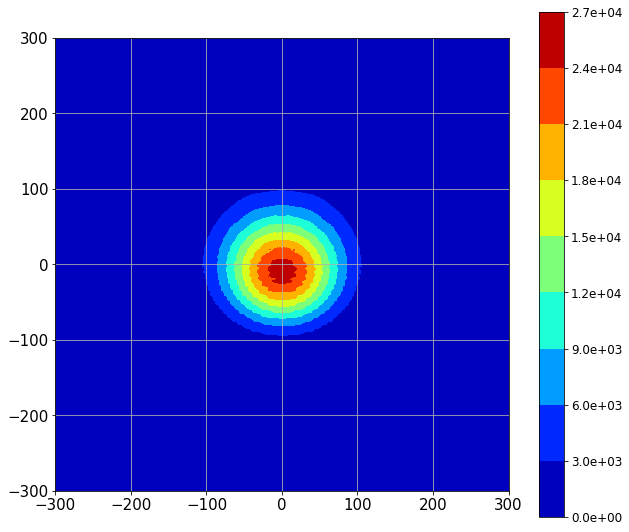

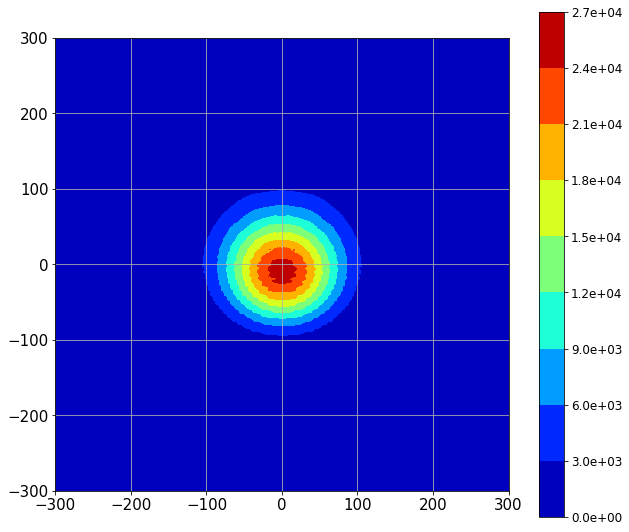

In [297]:
# Integral magnitude (|E|^2)
mag2 = calc_mag2(_data_dict)
_data_dict['mag2'] = {'x':_data_dict['U-Re']['x'], 'y':_data_dict['U-Re']['y'], 'z':mag2}
_data_dict['mag'] = {'x':_data_dict['U-Re']['x'], 'y':_data_dict['U-Re']['y'], 'z':np.sqrt(mag2)}
func.print_list(_data_dict['U-Re']['z'])
func.print_list(mag2)

mag2_grid = _data_dict['mag2']
integral_mag2_all = integral2D(mag2_grid['x'], mag2_grid['y'], mag2_grid['z'], doPlot=True)
print(f'integral mag2 all = {integral_mag2_all:e}')

integral_mag2_100 = integral2D(mag2_grid['x'], mag2_grid['y'], mag2_grid['z'], rmax=100, doPlot=True)
print(f'integral mag2 r<100 = {integral_mag2_100:e}')

# Integral E*V, E*U
Vreal_grid = _data_dict['V-Re']
Vimag_grid = _data_dict['V-Im']
Ureal_grid = _data_dict['U-Re']
Uimag_grid = _data_dict['U-Im']

# |integral|^2
print('----- V component ------')
integral_V2_all = calc_complex_integral_mag2(Vreal_grid, Vimag_grid, rmax=None, verbose=1)
print('----- U component ------')
integral_U2_all = calc_complex_integral_mag2(Ureal_grid, Uimag_grid, rmax=None, verbose=1)
print('------------------------')
print()
print(f'|Integral E_V|^2 = {integral_V2_all:e}')
print(f'|Integral E_U|^2 = {integral_U2_all:e}')

In [301]:
# S
S_V = integral_V2_all / integral_mag2_all
S_U = integral_U2_all / integral_mag2_all
def S_to_R(S):
    return np.sqrt(S/np.pi)
R_V = S_to_R(S_V)
R_U = S_to_R(S_U)
print(f'S_V = {S_V/mm/mm} mm^2')
print(f'R_V = {R_V/mm} mm')
print(f'S_U = {S_U/mm/mm} mm^2')
print(f'R_U = {R_U/mm} mm')

R_exp = func.interpolate1D(freq_list/GHz, w_mirror_list, 215)
B_exp = R_exp**2*np.pi
print(f'Expected beamsize (1/e half-width = 1sigma) = {R_exp/mm} mm')
print(f'Expected Beam Area = {B_exp/mm/mm} mm^2')
print(f'S_V/Exp. Beam Area = {S_V/B_exp*100} %')
print(f'R_V/Exp. beamsize = {R_V/R_exp}')

S_V = 44224.36418685031 mm^2
R_V = 118.64675440511144 mm
S_U = 52.65370198051645 mm^2
R_U = 4.093921577726352 mm
Expected beamsize (1/e half-width = 1sigma) = 94.99982636145329 mm
Expected Beam Area = 28352.770053441884 mm^2
S_V/Exp. Beam Area = 155.97898936679624 %
R_V/Exp. beamsize = 1.2489154869998058


(0.0, 742.2012644105886)

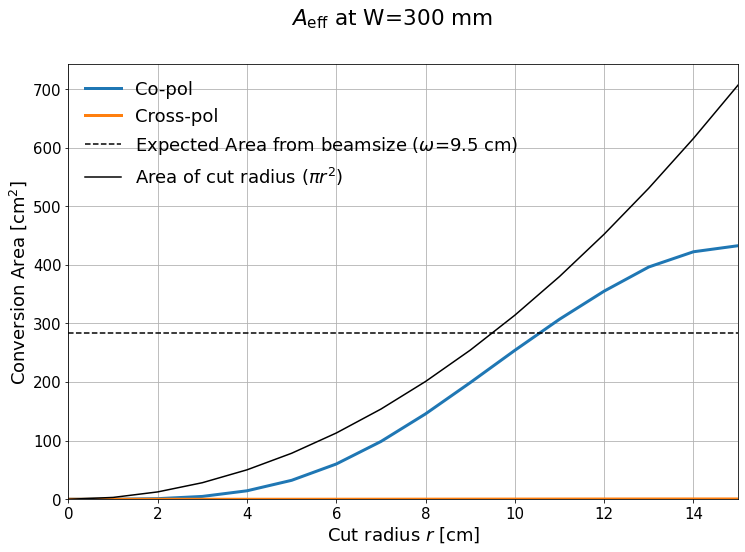

In [314]:
# rmax dependency
rmax_list = np.linspace(0, 150*mm, 16) # Mirror radius = 150 mm
integral_V2 = []
integral_U2 = []
for _r in rmax_list:
    integral_V2.append( calc_complex_integral_mag2(Vreal_grid, Vimag_grid, rmax=_r) )
    integral_U2.append( calc_complex_integral_mag2(Ureal_grid, Uimag_grid, rmax=_r) )
    pass
SV_list = integral_V2/integral_mag2_all
SU_list = integral_U2/integral_mag2_all

fig, ax = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle(r'$A_{\rm{eff}}$ at W=300 mm')
ax.plot(rmax_list/cm, SV_list/cm/cm, label='Co-pol', lw=3)
ax.plot(rmax_list/cm, SU_list/cm/cm, label='Cross-pol', lw=3)
ax.plot(rmax_list/cm, np.full(len(rmax_list), B_exp/cm/cm), label=f'Expected Area from beamsize ($\omega$={R_exp/cm:.1f} cm)', ls='--', c='k')
ax.plot(rmax_list/cm, np.power(rmax_list, 2.)*np.pi/cm/cm, label=r'Area of cut radius ($\pi r^2$)', c='k')
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Cut radius $r$ [cm]')
ax.set_ylabel(r'Conversion Area [cm$^2$]')
ax.set_xlim(np.array([rmax_list[0], rmax_list[-1]])/cm)
ax.set_ylim(bottom=0)

In [308]:
rmax_list_215GHz = rmax_list
SV_list_215GHz = SV_list
SU_list_215GHz = SU_list

### 170 GHz

input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_U_Re_W300_170GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_U_Im_W300_170GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_V_Re_W300_170GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_V_Im_W300_170GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-215GHz/170GHz/E-Field_W_Re_W300_170GHz.dat (type=3D_twova

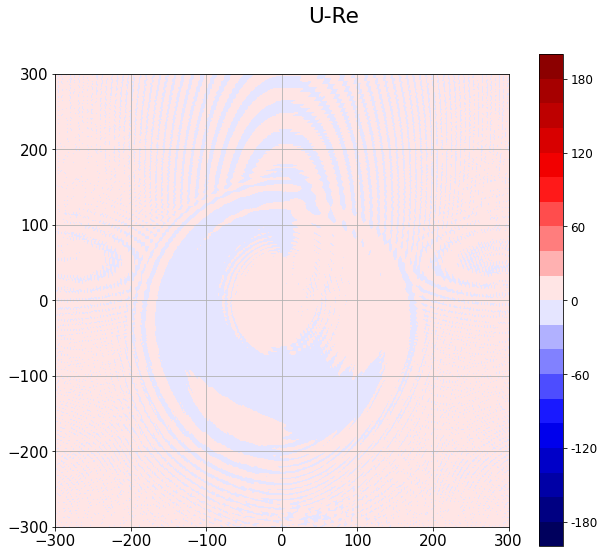

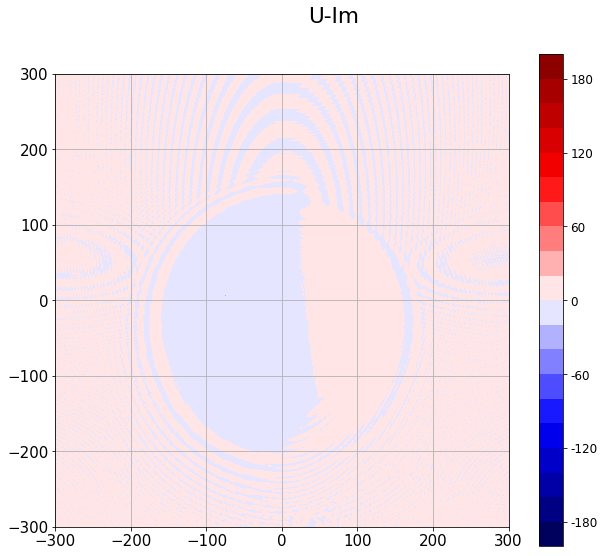

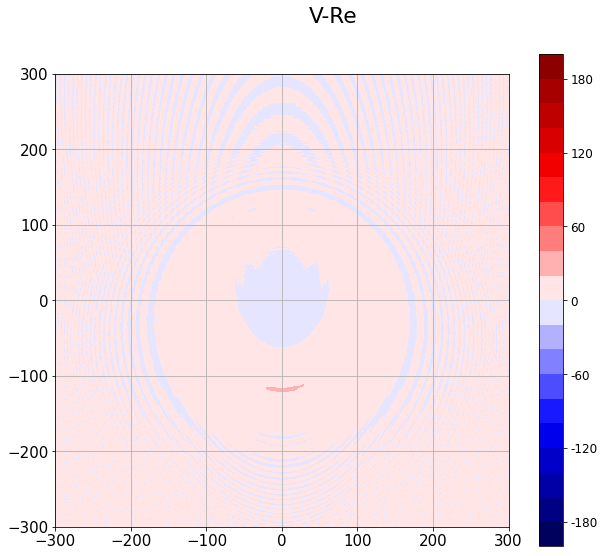

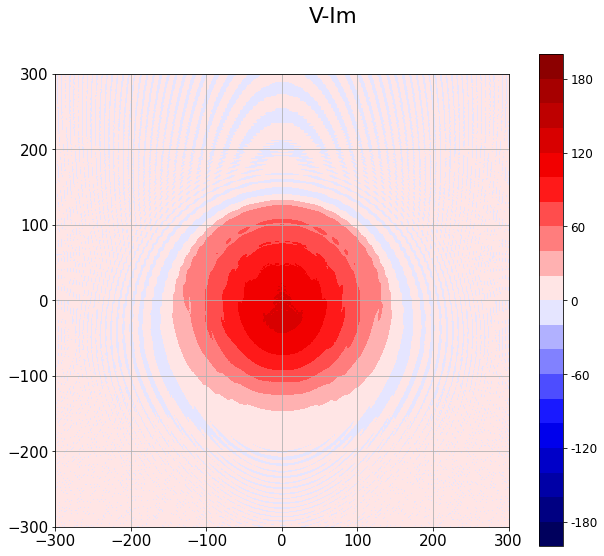

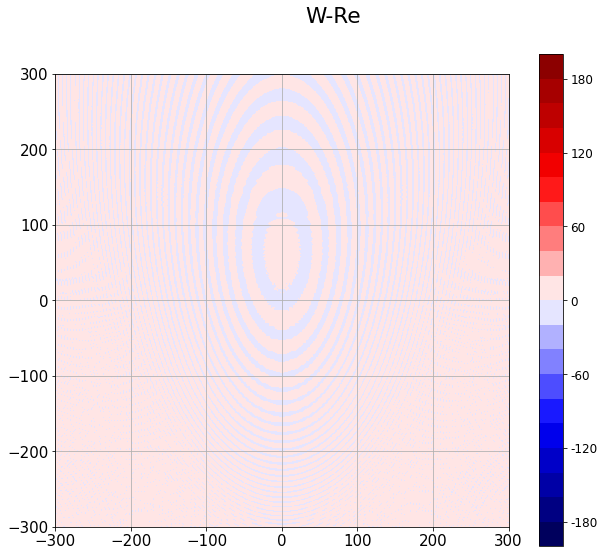

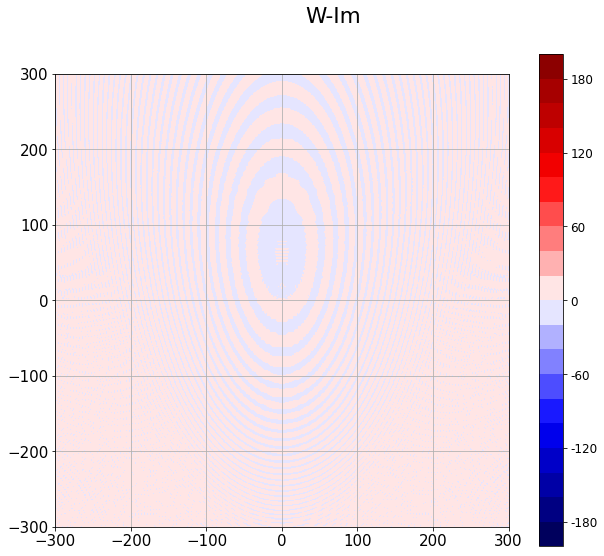

In [315]:
_indir = 'input/CST/215GHz_v8-4-215GHz/170GHz'
_preffix = 'E-Field_'
_suffix = '_W300_170GHz.dat'
_data_dict = read_CST_complex_field(
    indir=_indir,
    prefix=_prefix,
    suffix=_suffix,
    grid=( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) ),
    #levels=np.power(10, np.linspace(-30, 30, 21)/10), logz=True,
    levels=np.linspace(-200, 200, 20+1), logz=False, cmap='seismic', colorbarformat='%.0f',
    doPlot=True
)

print(_data_dict)

 (size=(361201,)) = [ 0.12612    0.0835575  0.040995  ... -0.11511   -0.18788   -0.26065  ]
mag2 (size=(361201,)) = [0.21162912 0.10458811 0.20059645 ... 9.00834509 0.90300029 8.61854082]
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
integral mag2 all = 3.494753e+02
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
integral mag2 r<100 = 3.494753e+02
----- V component ------
integral real (r<None) = 0.5741257773476719
integral imag (r<None) = 4.364797884431945
integral real^2 + integral imag^2 (r<None) = 19.38108098015665
----- U component ------
integral real (r<None) = -0.02730379018450105
integral imag (r<None) = -0.2934675684505231
integral real^2 + integral imag^2 (r<None) = 0.0868687106907017
------------------------

|Integral E_V|^2 = 1.938108e+01
|Integral E_U|^2 = 8.686871e-02


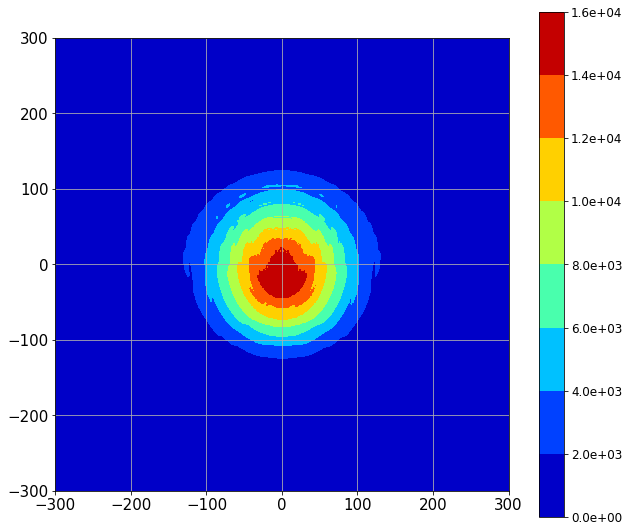

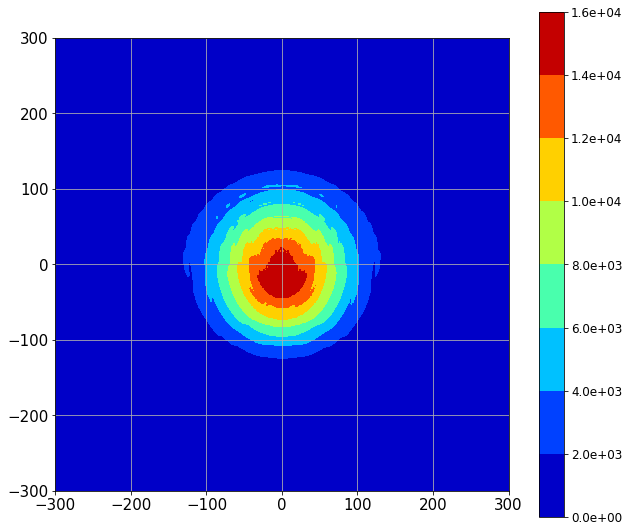

In [316]:
# Integral magnitude (|E|^2)
mag2 = calc_mag2(_data_dict)
_data_dict['mag2'] = {'x':_data_dict['U-Re']['x'], 'y':_data_dict['U-Re']['y'], 'z':mag2}
_data_dict['mag'] = {'x':_data_dict['U-Re']['x'], 'y':_data_dict['U-Re']['y'], 'z':np.sqrt(mag2)}
func.print_list(_data_dict['U-Re']['z'])
func.print_list(mag2)

mag2_grid = _data_dict['mag2']
integral_mag2_all = integral2D(mag2_grid['x'], mag2_grid['y'], mag2_grid['z'], doPlot=True)
print(f'integral mag2 all = {integral_mag2_all:e}')

integral_mag2_100 = integral2D(mag2_grid['x'], mag2_grid['y'], mag2_grid['z'], rmax=100, doPlot=True)
print(f'integral mag2 r<100 = {integral_mag2_100:e}')

# Integral E*V, E*U
Vreal_grid = _data_dict['V-Re']
Vimag_grid = _data_dict['V-Im']
Ureal_grid = _data_dict['U-Re']
Uimag_grid = _data_dict['U-Im']

# |integral|^2
print('----- V component ------')
integral_V2_all = calc_complex_integral_mag2(Vreal_grid, Vimag_grid, rmax=None, verbose=1)
print('----- U component ------')
integral_U2_all = calc_complex_integral_mag2(Ureal_grid, Uimag_grid, rmax=None, verbose=1)
print('------------------------')
print()
print(f'|Integral E_V|^2 = {integral_V2_all:e}')
print(f'|Integral E_U|^2 = {integral_U2_all:e}')

In [317]:
# S
S_V = integral_V2_all / integral_mag2_all
S_U = integral_U2_all / integral_mag2_all
def S_to_R(S):
    return np.sqrt(S/np.pi)
R_V = S_to_R(S_V)
R_U = S_to_R(S_U)
print(f'S_V = {S_V/cm/cm} cm^2')
print(f'R_V = {R_V/mm} mm')
print(f'S_U = {S_U/cm/cm} cm^2')
print(f'R_U = {R_U/mm} mm')

R_exp = func.interpolate1D(freq_list, w_mirror_list, 170.*GHz) # for 170 GHz
B_exp = R_exp**2*np.pi 
print(f'Expected beamsize (1/e half-width = 1sigma) = {R_exp/mm} mm')
print(f'Expected Beam Area = {B_exp/mm/mm} mm^2')
print(f'S_V/Exp. Beam Area = {S_V/B_exp*100} %')
print(f'R_V/Exp. beamsize = {R_V/R_exp}')

S_V = 554.5765110083146 cm^2
R_V = 132.86353378533192 mm
S_U = 2.4856893451900044 cm^2
R_U = 8.8950519535059 mm
Expected beamsize (1/e half-width = 1sigma) = 117.3544509517645 mm
Expected Beam Area = 43266.22500891529 mm^2
S_V/Exp. Beam Area = 128.1776977062456 %
R_V/Exp. beamsize = 1.1321558978614454


(0.0, 742.2012644105886)

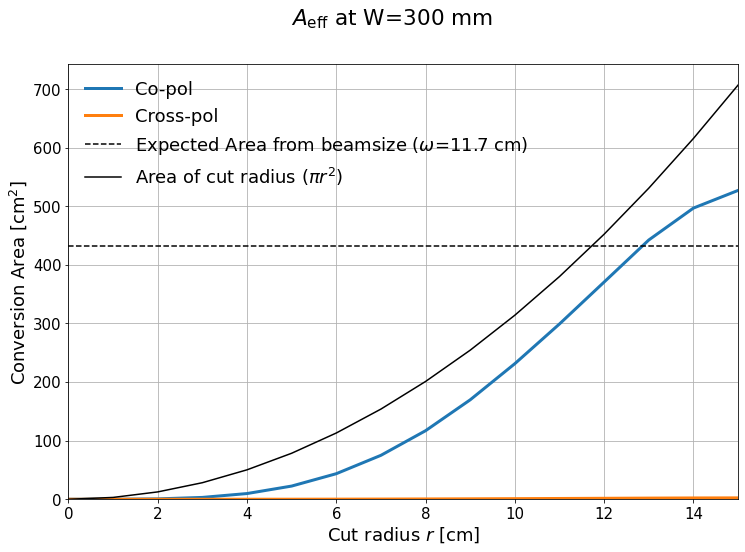

In [318]:
# rmax dependency
rmax_list = np.linspace(0, 150*mm, 16) # Mirror radius = 150 mm
integral_V2 = []
integral_U2 = []
for _r in rmax_list:
    integral_V2.append( calc_complex_integral_mag2(Vreal_grid, Vimag_grid, rmax=_r) )
    integral_U2.append( calc_complex_integral_mag2(Ureal_grid, Uimag_grid, rmax=_r) )
    pass
SV_list = integral_V2/integral_mag2_all
SU_list = integral_U2/integral_mag2_all

fig, ax = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle(r'$A_{\rm{eff}}$ at W=300 mm')
ax.plot(rmax_list/cm, SV_list/cm/cm, label='Co-pol', lw=3)
ax.plot(rmax_list/cm, SU_list/cm/cm, label='Cross-pol', lw=3)
ax.plot(rmax_list/cm, np.full(len(rmax_list), B_exp/cm/cm), label=f'Expected Area from beamsize ($\omega$={R_exp/cm:.1f} cm)', ls='--', c='k')
ax.plot(rmax_list/cm, np.power(rmax_list, 2.)*np.pi/cm/cm, label=r'Area of cut radius ($\pi r^2$)', c='k')
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Cut radius $r$ [cm]')
ax.set_ylabel(r'Conversion Area [cm$^2$]')
ax.set_xlim(np.array([rmax_list[0], rmax_list[-1]])/cm)
ax.set_ylim(bottom=0)

In [170]:
rmax_list_170GHz = rmax_list
SV_list_170GHz = SV_list
SU_list_170GHz = SU_list

### 260 GHz

input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_U_Re_W300_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_U_Im_W300_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_V_Re_W300_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_V_Im_W300_260GHz.dat (type=3D_twovalue)
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
input file = input/CST/215GHz_v8-4-260GHz/260GHz/E-Field_W_Re_W300_260GHz.dat (type=3D_twova

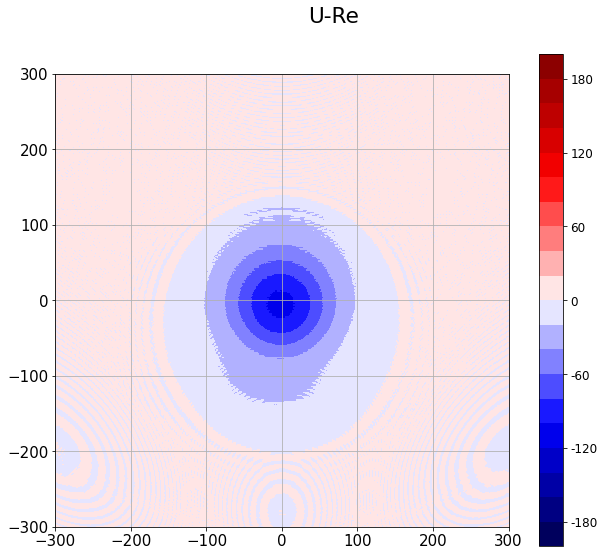

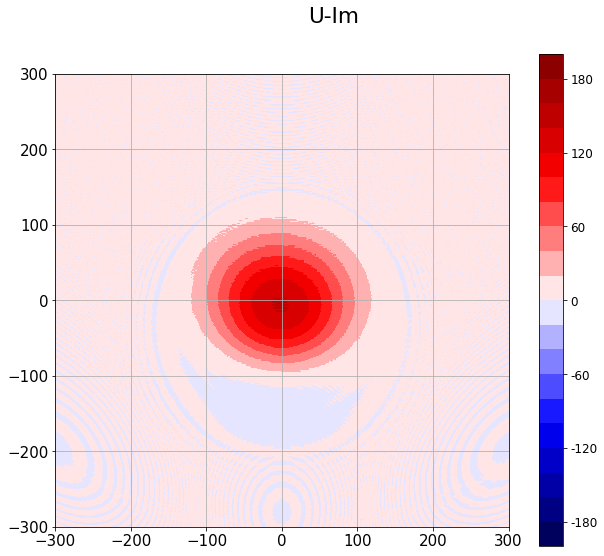

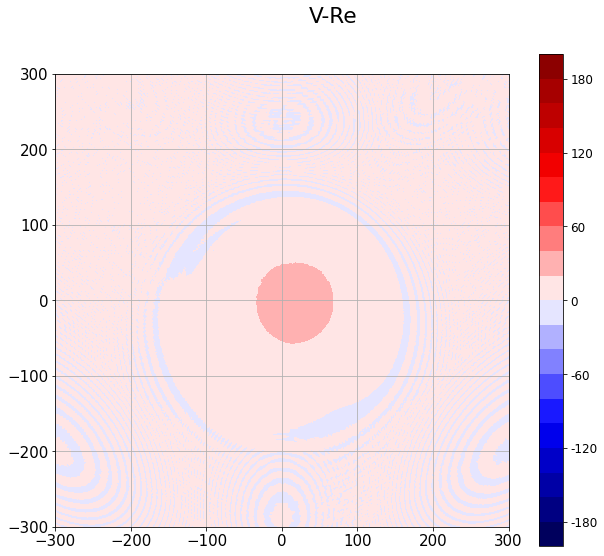

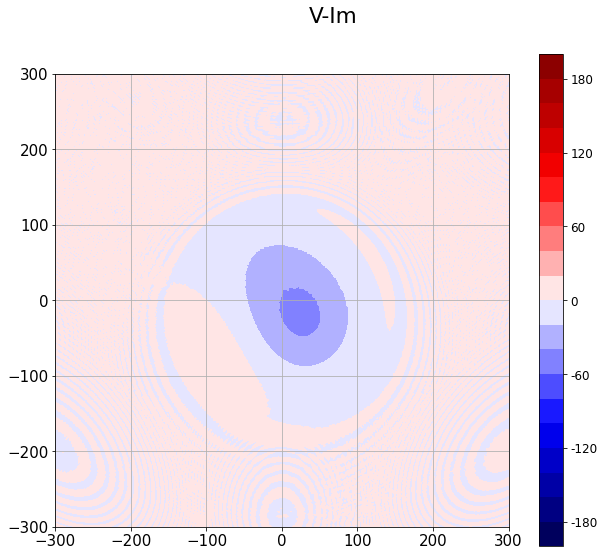

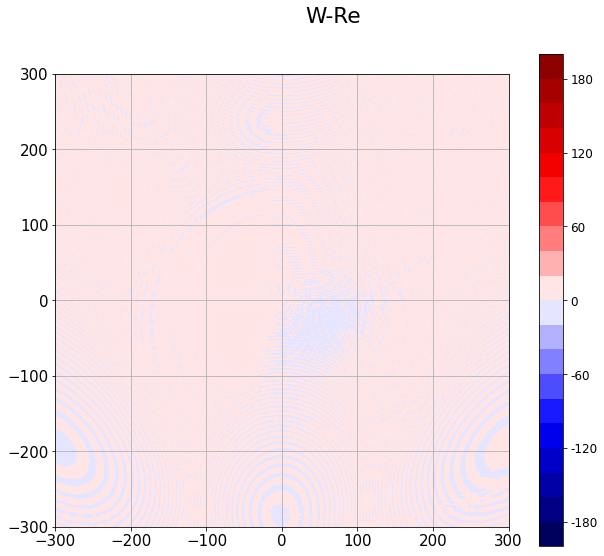

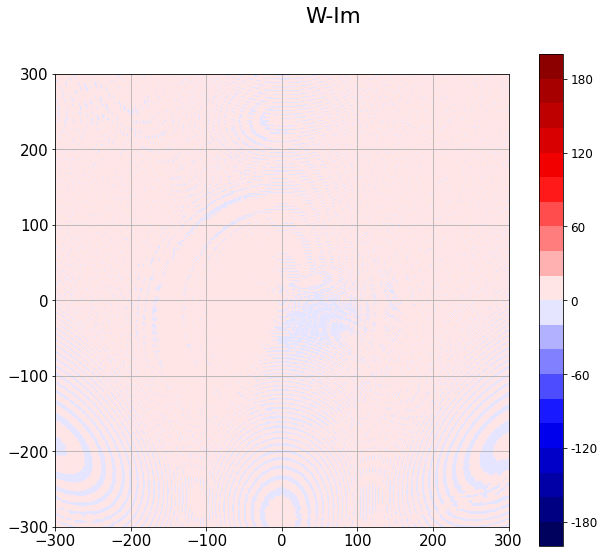

In [278]:
_indir = 'input/CST/215GHz_v8-4-260GHz/260GHz'
_preffix = 'E-Field_'
_suffix = '_W300_260GHz.dat'
_data_dict = read_CST_complex_field(
    indir=_indir,
    prefix=_prefix,
    suffix=_suffix,
    grid=( np.linspace(-300, 300, 600+1), np.linspace(-300, 300, 600+1) ),
    #levels=np.power(10, np.linspace(-30, 30, 21)/10), logz=True,
    levels=np.linspace(-200, 200, 20+1), logz=False, cmap='seismic', colorbarformat='%.0f',
    doPlot=True
)

print(_data_dict)

 (size=(361201,)) = [ 0.11073   0.147145  0.18356  ...  1.1583    0.23808  -0.68214 ]
mag2 (size=(361201,)) = [0.19521492 0.17955065 0.20978523 ... 3.67736589 0.23519583 5.00030096]
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
integral mag2 all = 3.551796e+02
x_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
y_list (size=(601,)) = [-300. -299. -298. ...  298.  299.  300.]
integral mag2 r<100 = 3.551796e+02
----- V component ------
integral real (r<None) = 0.6514578429116996
integral imag (r<None) = -0.7817718944764874
integral real^2 + integral imag^2 (r<None) = 1.0355646160845209
----- U component ------
integral real (r<None) = -2.2203229073481126
integral imag (r<None) = 2.671572909314863
integral real^2 + integral imag^2 (r<None) = 12.067135622679855
------------------------

|Integral E_V|^2 = 1.035565e+00
|Integral E_U|^2 = 1.206714e+01


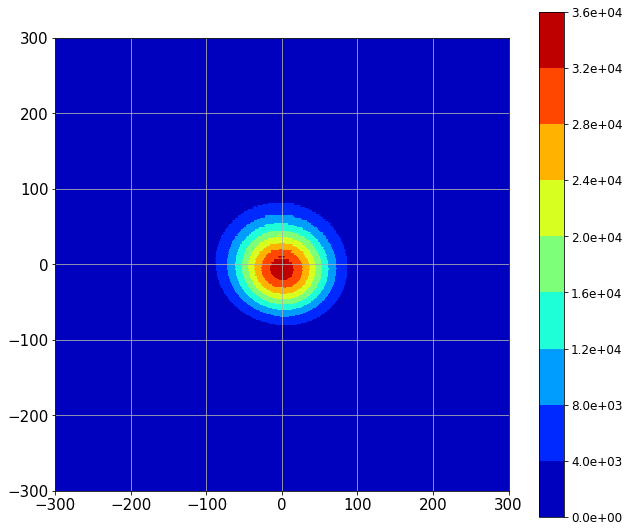

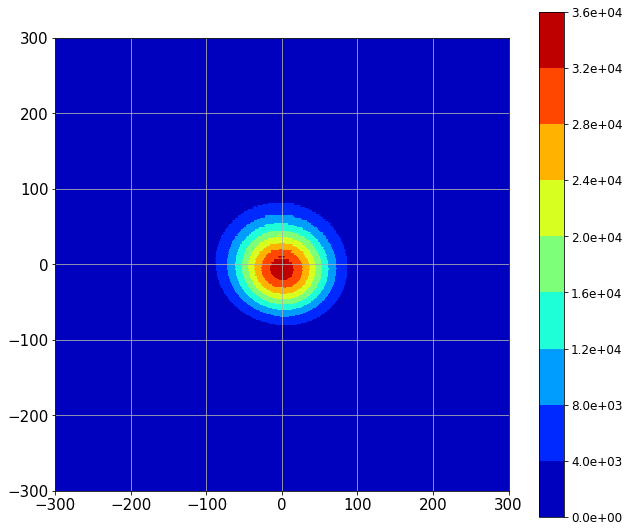

In [243]:
# Integral magnitude (|E|^2)
mag2 = calc_mag2(_data_dict)
_data_dict['mag2'] = {'x':_data_dict['U-Re']['x'], 'y':_data_dict['U-Re']['y'], 'z':mag2}
_data_dict['mag'] = {'x':_data_dict['U-Re']['x'], 'y':_data_dict['U-Re']['y'], 'z':np.sqrt(mag2)}
func.print_list(_data_dict['U-Re']['z'])
func.print_list(mag2)

mag2_grid = _data_dict['mag2']
integral_mag2_all = integral2D(mag2_grid['x'], mag2_grid['y'], mag2_grid['z'], doPlot=True)
print(f'integral mag2 all = {integral_mag2_all:e}')

integral_mag2_100 = integral2D(mag2_grid['x'], mag2_grid['y'], mag2_grid['z'], rmax=100, doPlot=True)
print(f'integral mag2 r<100 = {integral_mag2_100:e}')

# Integral E*V, E*U
Vreal_grid = _data_dict['V-Re']
Vimag_grid = _data_dict['V-Im']
Ureal_grid = _data_dict['U-Re']
Uimag_grid = _data_dict['U-Im']

# |integral|^2
print('----- V component ------')
integral_V2_all = calc_complex_integral_mag2(Vreal_grid, Vimag_grid, rmax=None, verbose=1)
print('----- U component ------')
integral_U2_all = calc_complex_integral_mag2(Ureal_grid, Uimag_grid, rmax=None, verbose=1)
print('------------------------')
print()
print(f'|Integral E_V|^2 = {integral_V2_all:e}')
print(f'|Integral E_U|^2 = {integral_U2_all:e}')

In [245]:
# S
S_V = integral_V2_all / integral_mag2_all
S_U = integral_U2_all / integral_mag2_all
def S_to_R(S):
    return np.sqrt(S/np.pi)
R_V = S_to_R(S_V)
R_U = S_to_R(S_U)
print(f'S_V = {S_V/cm/cm} cm^2')
print(f'R_V = {R_V/mm} mm')
print(f'S_U = {S_U/cm/cm} cm^2')
print(f'R_U = {R_U/mm} mm')

R_exp = func.interpolate1D(freq_list, w_mirror_list, 260.*GHz) # for 260 GHz
B_exp = R_exp**2*np.pi 
print(f'Expected beamsize (1/e half-width = 1sigma) = {R_exp/mm} mm')
print(f'Expected Beam Area = {B_exp/mm/mm} mm^2')
print(f'S_V/Exp. Beam Area = {S_V/B_exp*100} %')
print(f'R_V/Exp. beamsize = {R_V/R_exp}')

S_V = 29.15608081867507 cm^2
R_V = 30.464190071226025 mm
S_U = 339.74739576854273 cm^2
R_U = 103.99276651687083 mm
Expected beamsize (1/e half-width = 1sigma) = 80.75328658253565 mm
Expected Beam Area = 20486.618785430634 mm^2
S_V/Exp. Beam Area = 14.231768123400556 %
R_V/Exp. beamsize = 0.37725015736776774


Text(0, 0.5, 'Conversion Area [cm$^2$]')

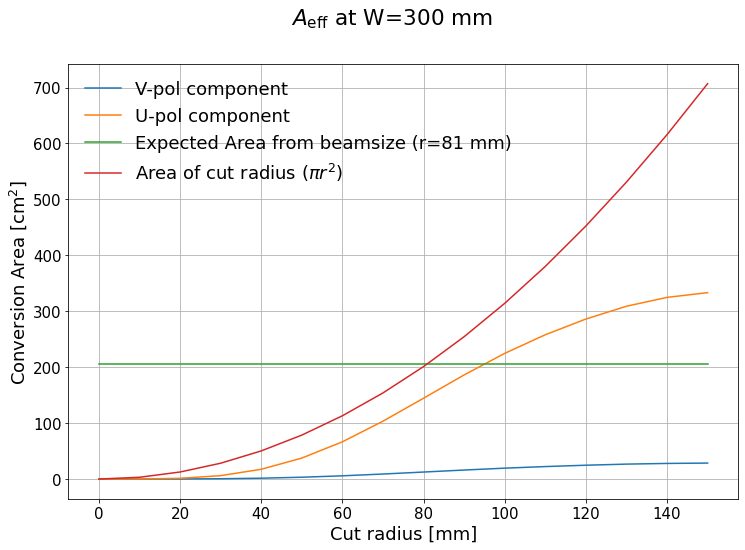

In [246]:
# rmax dependency
rmax_list = np.linspace(0, 150*mm, 16) # Mirror radius = 150 mm
integral_V2 = []
integral_U2 = []
for _r in rmax_list:
    integral_V2.append( calc_complex_integral_mag2(Vreal_grid, Vimag_grid, rmax=_r) )
    integral_U2.append( calc_complex_integral_mag2(Ureal_grid, Uimag_grid, rmax=_r) )
    pass
SV_list = integral_V2/integral_mag2_all
SU_list = integral_U2/integral_mag2_all

fig, ax = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle(r'$A_{\rm{eff}}$ at W=300 mm')
ax.plot(rmax_list/mm, SV_list/cm/cm, label='V-pol component')
ax.plot(rmax_list/mm, SU_list/cm/cm, label='U-pol component')
ax.plot(rmax_list/mm, np.full(len(rmax_list), B_exp/cm/cm), label=f'Expected Area from beamsize (r={R_exp/mm:.0f} mm)')
ax.plot(rmax_list/mm, np.power(rmax_list, 2.)*np.pi/cm/cm, label=r'Area of cut radius ($\pi r^2$)')
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Cut radius [mm]')
ax.set_ylabel(r'Conversion Area [cm$^2$]')

In [247]:
rmax_list_260GHz = rmax_list
SV_list_260GHz = SV_list
SU_list_260GHz = SU_list

### Summary

S V-pol = 527.0826814457722 cm^2 @ 170 GHz @ r=15.0 cm
S V-pol = 432.737327531002 cm^2 @ 215 GHz @ r=15.0 cm
S V-pol = 28.527923112500552 cm^2 @ 260 GHz @ r=15.0 cm
S U-pol = 2.368193388973352 cm^2 @ 170 GHz @ r=15.0 cm
S U-pol = 0.5121305261930652 cm^2 @ 215 GHz @ r=15.0 cm
S U-pol = 333.2567379905442 cm^2 @ 260 GHz @ r=15.0 cm
Spillover = 11.4 K @ 170 GHz @ r=15.0 cm
Spillover = 2.0 K @ 215 GHz @ r=15.0 cm
Spillover = 0.3 K @ 260 GHz @ r=15.0 cm


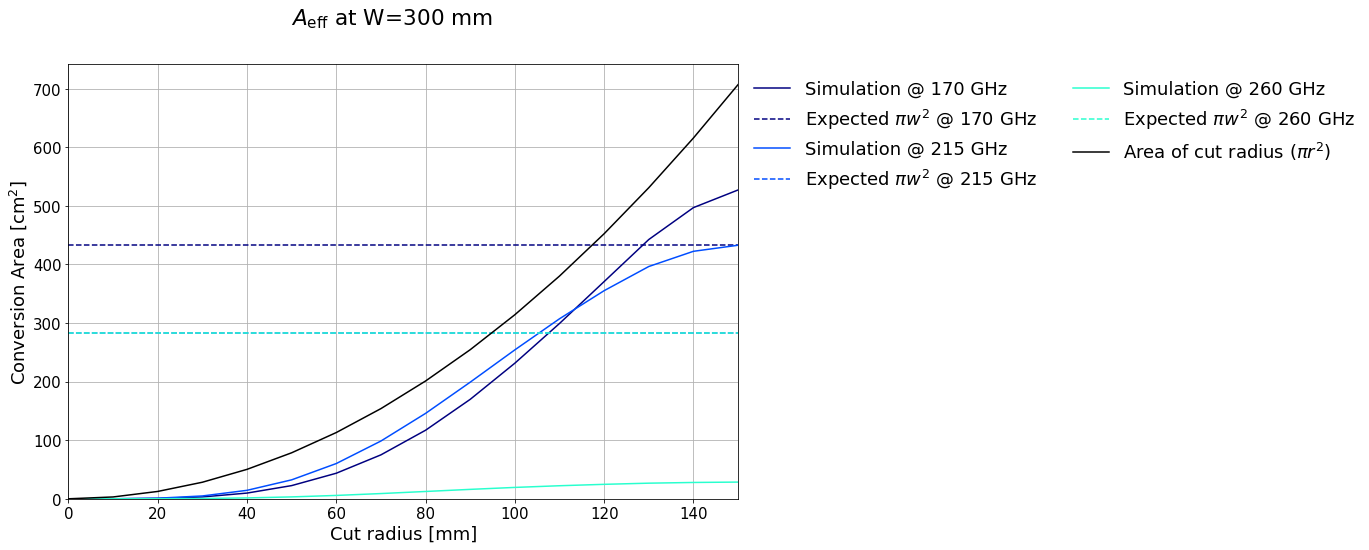

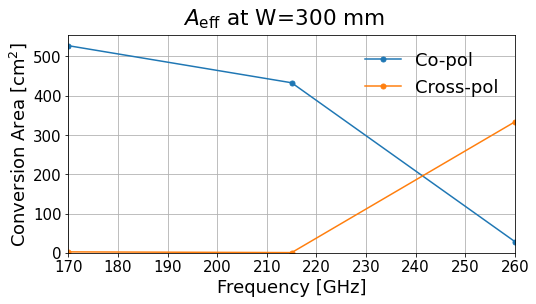

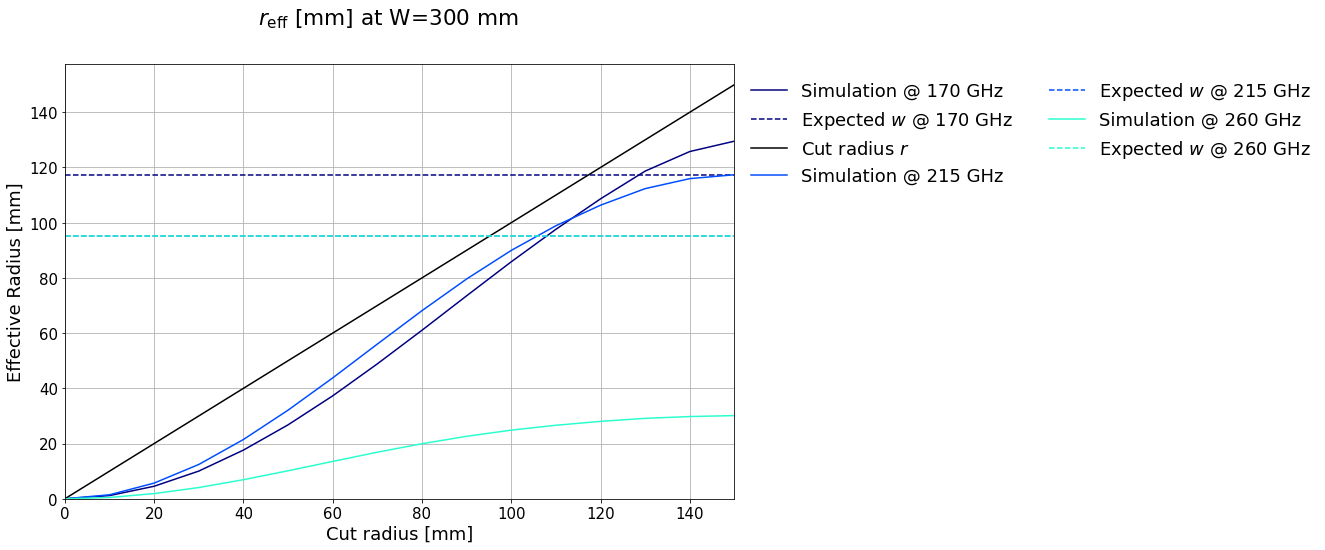

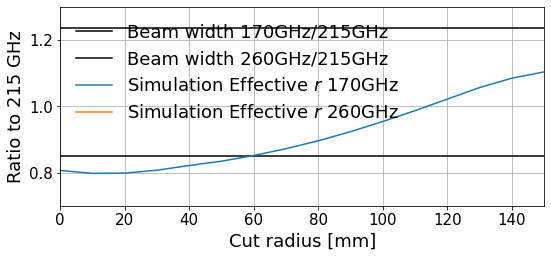

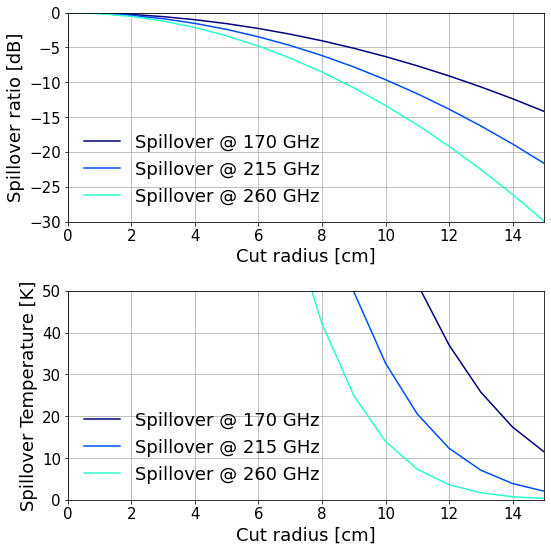

In [319]:
# General
rmax_list = rmax_list_170GHz
colors = [ mpcm.jet(r) for r in np.linspace(0, 1, 6) ]

# Expectation
w_170GHz = func.interpolate1D(freq_list, w_mirror_list, 170*GHz)
w_215GHz = func.interpolate1D(freq_list, w_mirror_list, 215*GHz)
w_260GHz = func.interpolate1D(freq_list, w_mirror_list, 260*GHz)
Bexp_170GHz = w_170GHz**2 * np.pi
Bexp_215GHz = w_215GHz**2 * np.pi
Bexp_260GHz = w_215GHz**2 * np.pi

# Effective Area
fig, ax = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle(r'$A_{\rm{eff}}$ at W=300 mm')
ax.plot(rmax_list_170GHz/mm, SV_list_170GHz/cm/cm, label='Simulation @ 170 GHz', c=colors[0])
ax.plot(rmax_list/mm, np.full(len(rmax_list), Bexp_170GHz/cm/cm), label=f'Expected $\pi w^2$ @ 170 GHz', ls='--', c=colors[0])
#ax.plot(rmax_list/mm, np.full(len(rmax_list), Bexp_170GHz*2./cm/cm), label=f'Expected $2\pi w^2$ @ 170 GHz', ls=':', c=colors[0])
ax.plot(rmax_list_215GHz/mm, SV_list_215GHz/cm/cm, label='Simulation @ 215 GHz', c=colors[1])
ax.plot(rmax_list/mm, np.full(len(rmax_list), Bexp_215GHz/cm/cm), label=f'Expected $\pi w^2$ @ 215 GHz', ls='--', c=colors[1])
#ax.plot(rmax_list/mm, np.full(len(rmax_list), Bexp_215GHz*2./cm/cm), label=f'Expected $2\pi w^2$ @ 215 GHz', ls=':', c=colors[1])
ax.plot(rmax_list_260GHz/mm, SV_list_260GHz/cm/cm, label='Simulation @ 260 GHz', c=colors[2])
ax.plot(rmax_list/mm, np.full(len(rmax_list), Bexp_260GHz/cm/cm), label=f'Expected $\pi w^2$ @ 260 GHz', ls='--', c=colors[2])
ax.plot(rmax_list/mm, np.power(rmax_list, 2.)*np.pi/cm/cm, label=r'Area of cut radius ($\pi r^2$)', c='k')
ax.grid(True)
ax.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('Cut radius [mm]')
ax.set_ylabel(r'Conversion Area [cm$^2$]')
ax.set_xlim([rmax_list[0]/mm, rmax_list[-1]/mm])
ax.set_ylim(bottom=0.)

# Effective Area v.s Frequency  @ cur r=300 mm
fig, ax = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(r'$A_{\rm{eff}}$ at W=300 mm')
ax.plot([170, 215, 260], np.array([SV_list_170GHz[-1], SV_list_215GHz[-1], SV_list_260GHz[-1]])/cm/cm, 
        label='Co-pol', marker='o', markersize=5)
ax.plot([170, 215, 260], np.array([SU_list_170GHz[-1], SU_list_215GHz[-1], SU_list_260GHz[-1]])/cm/cm, 
        label='Cross-pol', marker='o', markersize=5)
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel(r'Conversion Area [cm$^2$]')
ax.set_xlim([170, 260])
ax.set_ylim(bottom=0.)


# Effective Radius (sqrt(Aeff/pi))
def A_to_R(A): return np.sqrt(A/np.pi)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle(r'$r_{\rm{eff}}$ [mm] at W=300 mm')
ax.plot(rmax_list_170GHz/mm, A_to_R(SV_list_170GHz)/mm, label='Simulation @ 170 GHz', c=colors[0])
ax.plot(rmax_list/mm, np.full(len(rmax_list), w_170GHz/mm), label=f'Expected $w$ @ 170 GHz', ls='--', c=colors[0])
#ax.plot(rmax_list/mm, np.full(len(rmax_list), w_170GHz*np.sqrt(2)/mm), label=r'Expected $\sqrt{2} w$ @ 170 GHz', ls=':', c=colors[0])
ax.plot(rmax_list/mm, rmax_list/mm, label=r'Cut radius $r$', c='k')
ax.plot(rmax_list_215GHz/mm, A_to_R(SV_list_215GHz)/mm, label='Simulation @ 215 GHz', c=colors[1])
ax.plot(rmax_list/mm, np.full(len(rmax_list), w_215GHz/mm), label=f'Expected $w$ @ 215 GHz', ls='--', c=colors[1])
#ax.plot(rmax_list/mm, np.full(len(rmax_list), w_215GHz*np.sqrt(2)/mm), label=r'Expected $\sqrt{2} w$ @ 215 GHz', ls=':', c=colors[1])
ax.plot(rmax_list_260GHz/mm, A_to_R(SV_list_260GHz)/mm, label='Simulation @ 260 GHz', c=colors[2])
ax.plot(rmax_list/mm, np.full(len(rmax_list), w_215GHz/mm), label=f'Expected $w$ @ 260 GHz', ls='--', c=colors[2])
ax.grid(True)
ax.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('Cut radius [mm]')
ax.set_ylabel(r'Effective Radius [mm]')
ax.set_xlim([rmax_list[0]/mm, rmax_list[-1]/mm])
ax.set_ylim(bottom=0.)


# Ratio plot
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(rmax_list/mm, np.full(len(rmax_list), w_170GHz/w_215GHz), label=r'Beam width 170GHz/215GHz', c='k')
ax.plot(rmax_list/mm, np.full(len(rmax_list), w_260GHz/w_215GHz), label=r'Beam width 260GHz/215GHz', c='k')
ax.plot(rmax_list/mm, np.full(len(rmax_list), A_to_R(SV_list_170GHz)/A_to_R(SV_list_215GHz)), label=r'Simulation Effective $r$ 170GHz')
ax.plot(rmax_list/mm, np.full(len(rmax_list), A_to_R(SV_list_260GHz)/A_to_R(SV_list_215GHz)), label=r'Simulation Effective $r$ 260GHz')
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Cut radius [mm]')
ax.set_ylabel(r'Ratio to 215 GHz')
ax.set_xlim([rmax_list[0]/mm, rmax_list[-1]/mm])
ax.set_ylim([0.7, 1.3])
fig.tight_layout()


# Spillover
spillover_170GHz = calc_edgeTaper(r=rmax_list, w=w_170GHz)
spillover_215GHz = calc_edgeTaper(r=rmax_list, w=w_215GHz)
spillover_260GHz = calc_edgeTaper(r=rmax_list, w=w_260GHz)
Troom = 300
spilloverTemp_170GHz = spillover_170GHz*Troom
spilloverTemp_215GHz = spillover_215GHz*Troom
spilloverTemp_260GHz = spillover_260GHz*Troom
# Plot
fig, axs = plt.subplots(2, 1, figsize=(8,8))
# dB
ax = axs[0]
ax.plot(rmax_list/cm, func.ratio_to_dB(spillover_170GHz), label=r'Spillover @ 170 GHz', c=colors[0])
ax.plot(rmax_list/cm, func.ratio_to_dB(spillover_215GHz), label=r'Spillover @ 215 GHz', c=colors[1])
ax.plot(rmax_list/cm, func.ratio_to_dB(spillover_260GHz), label=r'Spillover @ 260 GHz', c=colors[2])
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Cut radius [cm]')
ax.set_ylabel(r'Spillover ratio [dB]')
ax.set_xlim([rmax_list[0]/cm, rmax_list[-1]/cm])
ax.set_ylim([-30, 0])
# Temperature
ax = axs[1]
ax.plot(rmax_list/cm, spilloverTemp_170GHz, label=r'Spillover @ 170 GHz', c=colors[0])
ax.plot(rmax_list/cm, spilloverTemp_215GHz, label=r'Spillover @ 215 GHz', c=colors[1])
ax.plot(rmax_list/cm, spilloverTemp_260GHz, label=r'Spillover @ 260 GHz', c=colors[2])
ax.grid(True)
ax.legend(frameon=False)
ax.set_xlabel('Cut radius [cm]')
ax.set_ylabel(r'Spillover Temperature [K]')
ax.set_xlim([rmax_list[0]/cm, rmax_list[-1]/cm])
ax.set_ylim([0, 50])
fig.tight_layout()

# Print effective areas
print(f"S V-pol = {SV_list_170GHz[-1]/cm/cm} cm^2 @ 170 GHz @ r={rmax_list_170GHz[-1]/cm} cm")
print(f"S V-pol = {SV_list_215GHz[-1]/cm/cm} cm^2 @ 215 GHz @ r={rmax_list_215GHz[-1]/cm} cm")
print(f"S V-pol = {SV_list_260GHz[-1]/cm/cm} cm^2 @ 260 GHz @ r={rmax_list_260GHz[-1]/cm} cm")
print(f"S U-pol = {SU_list_170GHz[-1]/cm/cm} cm^2 @ 170 GHz @ r={rmax_list_170GHz[-1]/cm} cm")
print(f"S U-pol = {SU_list_215GHz[-1]/cm/cm} cm^2 @ 215 GHz @ r={rmax_list_215GHz[-1]/cm} cm")
print(f"S U-pol = {SU_list_260GHz[-1]/cm/cm} cm^2 @ 260 GHz @ r={rmax_list_260GHz[-1]/cm} cm")
# Print spillover temperature
print(f"Spillover = {spilloverTemp_170GHz[-1]:.1f} K @ 170 GHz @ r={rmax_list[-1]/cm} cm")
print(f"Spillover = {spilloverTemp_215GHz[-1]:.1f} K @ 215 GHz @ r={rmax_list[-1]/cm} cm")
print(f"Spillover = {spilloverTemp_260GHz[-1]:.1f} K @ 260 GHz @ r={rmax_list[-1]/cm} cm")

# The End

# Misc.

# Obsolete scripts

### Phase check (E-field u-component) (Old)

input file = input/CST/v4-1HS2//E-field_u_phase_w200.txt (type=3D_twovalue)
x_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
y_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
input file = input/CST/v4-1HS2//E-field_u_phase_w500.txt (type=3D_twovalue)
x_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
y_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]


Text(0.5, 0.98, 'z from mirror = 500 mm')

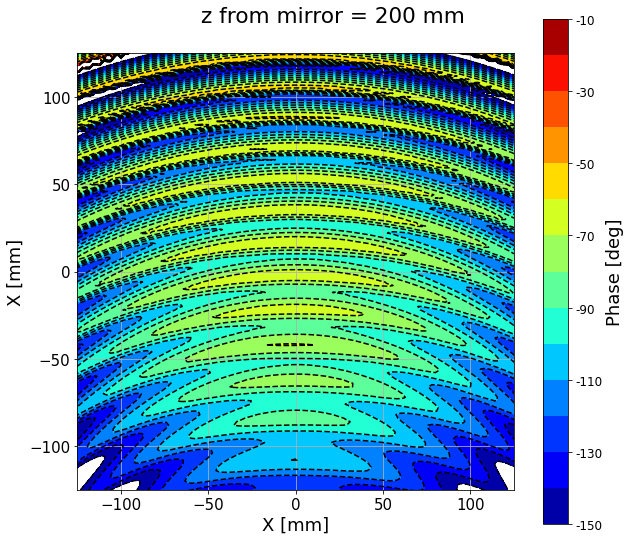

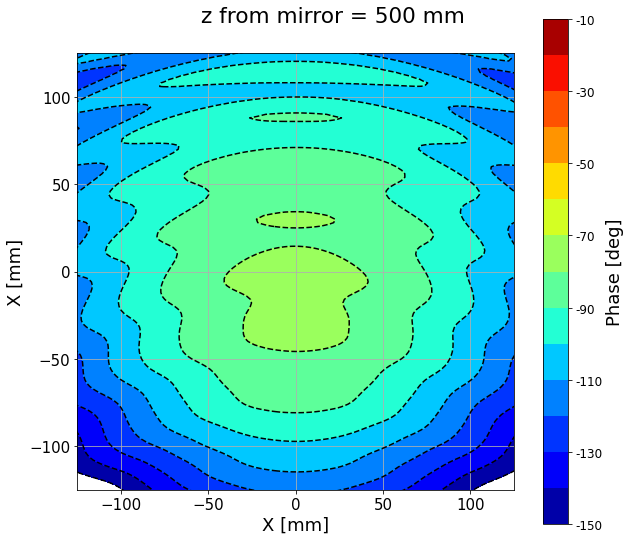

In [51]:
#_contourtype = None
#_levels = np.arange(-180, 180, 30)

#_contourtype = 'line'
_contourtype = 'fill-line'
_levels = np.arange(-150, 0, 10)

_indir = 'input/CST/v4-1HS2/'
_infile = 'E-field_u_phase_w200.txt'
_raw_data = read_CST(f'{_indir}/{_infile}', '3D_twovalue', verbose=0)
fig, ax, _data_grid = plot2D_key(_raw_data, keys=['x', 'y', 'val0'], logz=False,
                                 contourtype=_contourtype, levels = _levels, colorbarFormat='%.0f',
                                xlabel='X [mm]', ylabel='Y [mm]', zlabel='Phase [deg]')
ax.set_xlim([-125, 125])
ax.set_ylim([-125, 125])
fig.suptitle('z from mirror = 200 mm')
_infile = 'E-field_u_phase_w500.txt'
_raw_data = read_CST(f'{_indir}/{_infile}', '3D_twovalue', verbose=0)
fig, ax, _data_grid = plot2D_key(_raw_data, keys=['x', 'y', 'val0'], logz=False,
                                 contourtype=_contourtype, levels = _levels, colorbarFormat='%.0f',
                                xlabel='X [mm]', ylabel='Y [mm]', zlabel='Phase [deg]')
ax.set_xlim([-125, 125])
ax.set_ylim([-125, 125])
fig.suptitle('z from mirror = 500 mm')

input file = input/CST/v4-1HS2//E-field_v_phase_w200.txt (type=3D_twovalue)
x_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]
y_list (size=(501,)) = [-500. -498. -496. ...  496.  498.  500.]


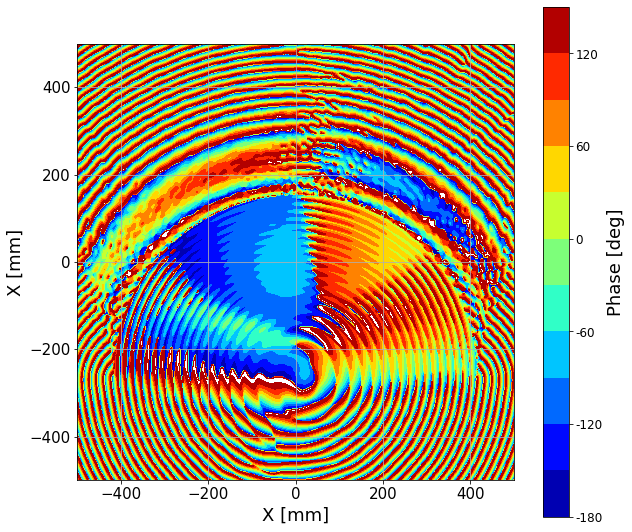

In [52]:
_indir = 'input/CST/v4-1HS2/'
_infile = 'E-field_v_phase_w200.txt'
_raw_data = read_CST(f'{_indir}/{_infile}', '3D_twovalue', verbose=0)
fig, ax, _data_grid = plot2D_key(_raw_data, keys=['x', 'y', 'val0'], logz=False,
                                 levels = np.arange(-180, 180, 30), colorbarFormat='%.0f',
                                xlabel='X [mm]', ylabel='Y [mm]', zlabel='Phase [deg]')

### Z/Abs check (E-field $|E_w| / |E|$) (Old)

In [ ]:
_levels = np.arange(0, 150, 10)

_indir = 'input/CST/v4-1HS2/'
_infile = 'E-field_w_mag_w500.txt'
_raw_data1 = read_CST(f'{_indir}/{_infile}', '3D_twovalue', verbose=0)
fig, ax, _data_grid = plot2D_key(_raw_data1, keys=['x', 'y', 'val0'], logz=False,
                                 levels = _levels,
                                xlabel='X [mm]', ylabel='Y [mm]', zlabel=r'$|E_z|$ [V/m]')
fig.suptitle(r'z component $|E_z|$')


_indir = 'input/CST/v4-1HS2/'
_infile = 'E-field_abs_mag_w500.txt'
_raw_data2 = read_CST(f'{_indir}/{_infile}', '3D_twovalue', verbose=0)
fig, ax, _data_grid = plot2D_key(_raw_data2, keys=['x', 'y', 'val0'], logz=False,
                                 levels = _levels,
                                xlabel='X [mm]', ylabel='Y [mm]', zlabel=r'$|E|$ [V/m]')
fig.suptitle(r'Absolute component $|E|$')

_data_ratio = _raw_data1
_data_ratio['val0'] = _data_ratio['val0'] / _raw_data2['val0']
fig, ax, _data_grid = plot2D_key(_data_ratio, keys=['x', 'y', 'val0'], logz=False,
                                 levels = np.arange(0, 0.2, 0.01),
                                xlabel='X [mm]', ylabel='Y [mm]', zlabel=r'$|E_z|/|E|$')
fig.suptitle(r'$|E_z| / |E|$')
ax.set_xlim(-125, 125)
ax.set_ylim(-125, 125)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
for i, (_data, _label) in enumerate(zip(_datalist, _labels)):
    _x = _data['angle']
    _y = _data['val']
    _x, tmp = func.average_list(_x, 10)
    _y, tmp = func.average_list(_y, 10)
    #sc = ax[0].scatter(_x, _y, label=_label, s=10)
    sc = ax[0].plot(_x, _y, label=_label, lw=2)
    if i == 0:
        _y0 = _y
    else:
        #ax[1].scatter( _x, np.divide(_y, _y0), c=sc.get_ec(), s=10 )
        ax[1].plot( _x, np.divide(_y, _y0), c=sc[0].get_c(), lw=2 )
        pass
    pass
ax[0].legend(frameon=False)
ax[0].grid(True)
ax[1].grid(True)
ax[1].plot([-180,180],[1,1],c='k',lw=1)

ax[0].set_xlim(-90, 90)
ax[1].set_xlim(-90, 90)
fig.tight_layout()